<strong><u> Deep-learning-based convolutional neural networks to classify error messages for predictive maintenance using info/error/warning messages from log files </strong></u>

 * We have used conventional machine learning alogorithms like Naive Bayes, Support Vector Machines, Logistic Regression, etc., in the previous notebook. Today, we will be using a deep-learning-based convolutional neural network architecture to classify error messages from log files.
 * This model is trained to predict 28 different error messages using system log file messages
 * Applied tokenization and encodings to derive word features in vector representations.
 * Used a 5-min window of system log text messages prior to an error event
 * Processed the log texts using the following: 1. stemming 2. remove long and domain specific texts 3. Alpha Numeric  characters and 4. numbers replaced by a place holder

<u>Import necessary modules:</u>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.models import Sequential
from keras.initializers import Constant
from keras.utils import to_categorical

<u>Load the data</u>

In [2]:
logstash = pd.read_excel('051723_Live_log_data.xlsx', sheet_name='LogStashLogs')
logstash['Date'] = pd.to_datetime(logstash.Date)
logstash['Date'] = logstash['Date'].dt.tz_convert(None)
logstash = logstash[logstash.Date.notnull()]
logstash = logstash.sort_values(['Date'], ascending=True)

<u> Exploratory data analysis </u>
    
* Count the occurance of error codes in the stash file logs

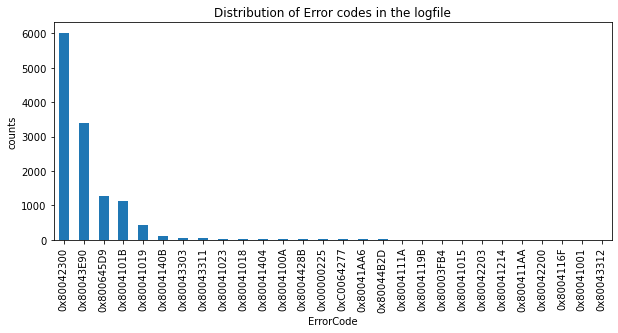

In [3]:
plt.figure(figsize=(10,4))
logstash.ErrorCode.value_counts().plot(kind='bar')
plt.xlabel('ErrorCode')
plt.ylabel('counts')
plt.title('Distribution of Error codes in the logfile')
plt.show()

* Frequency of the occurance of each error code within an interval of every hour

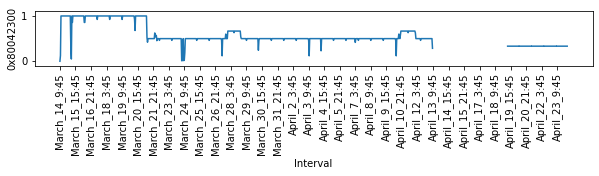

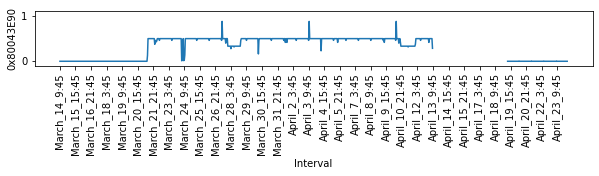

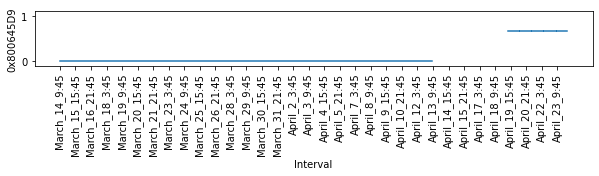

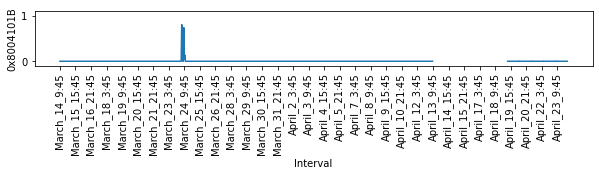

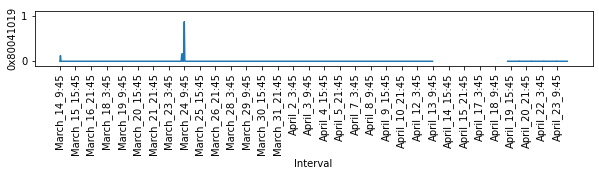

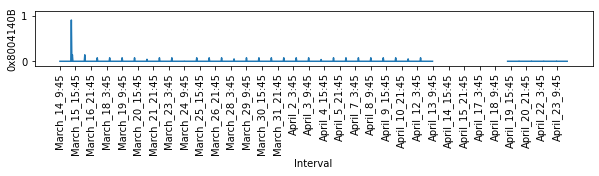

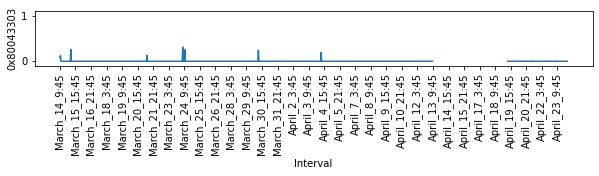

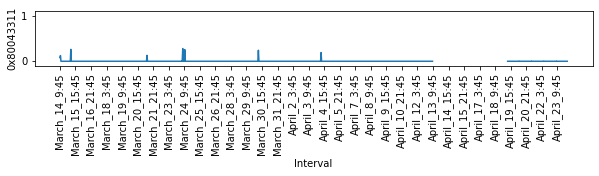

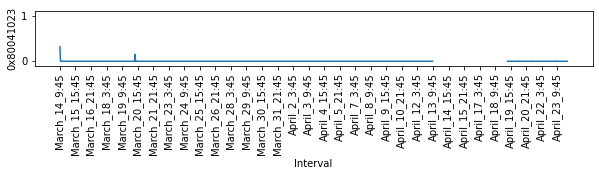

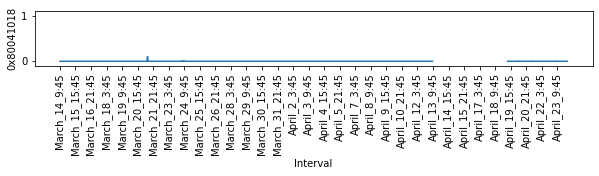

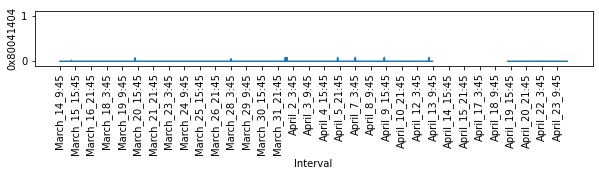

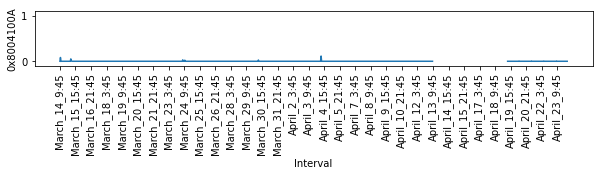

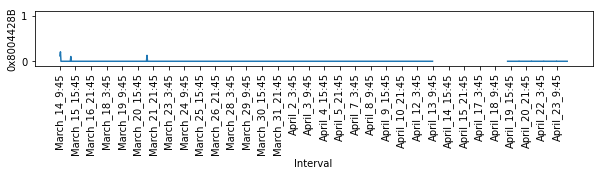

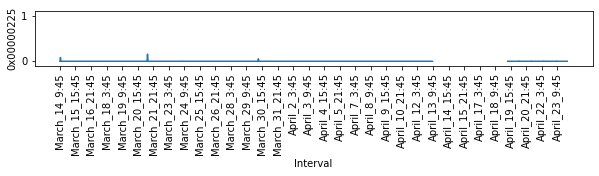

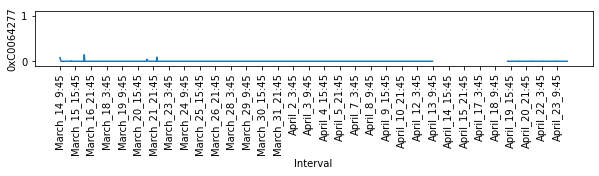

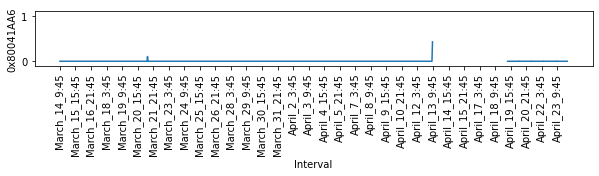

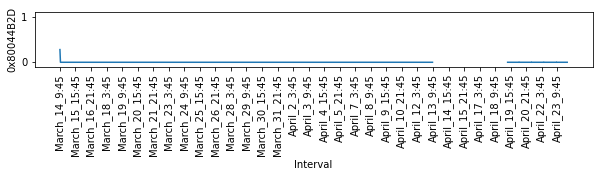

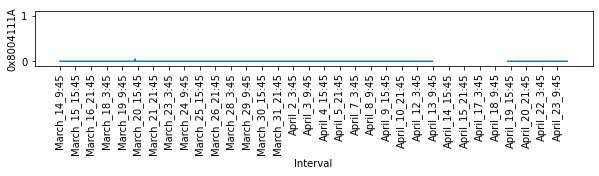

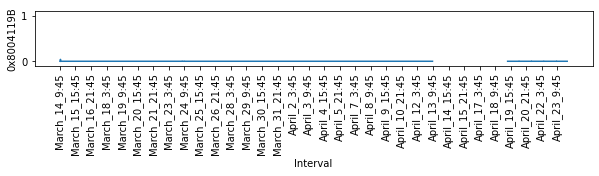

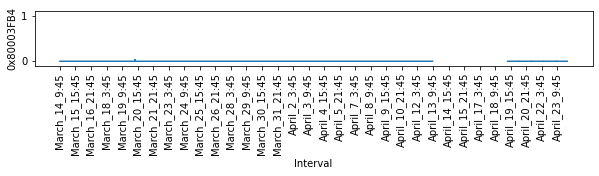

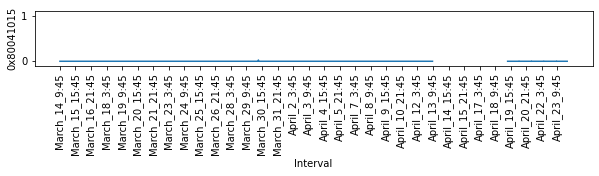

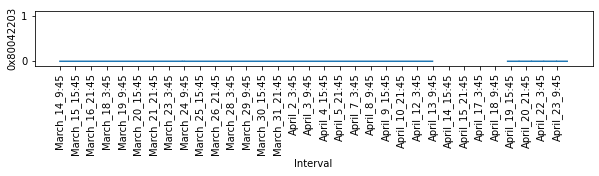

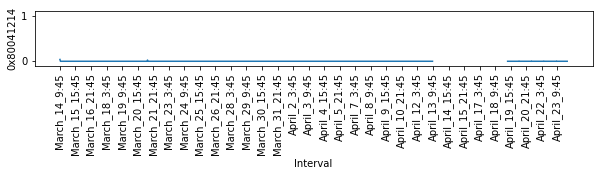

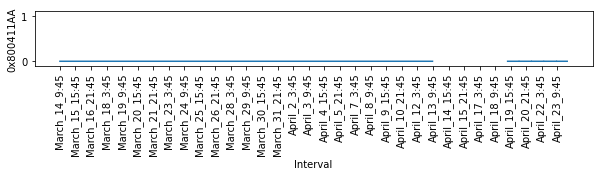

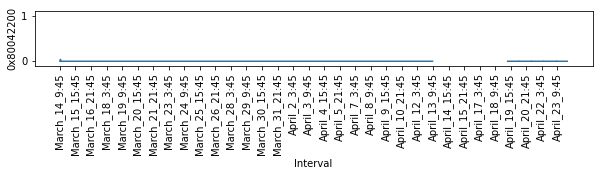

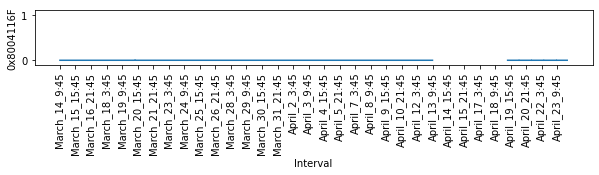

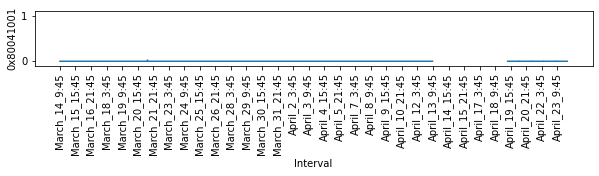

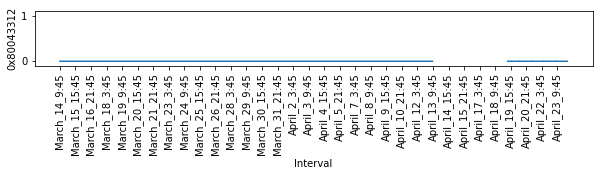

In [4]:
from datetime import datetime
import calendar

def convert_interval_to_date(string):
    datetimelist = []
    for i in range(len(string)):
        interval = string[i].strip("()").split(", ")
        date1 = datetime.strptime(interval[0], "%Y-%m-%d %H:%M:%S.%f")
        date2 = datetime.strptime(interval[0], "%Y-%m-%d %H:%M:%S.%f")
        calendar_month = calendar.month_name[date1.month]
        datetimelist.append(calendar_month + "_" + str(date1.day) + "_" + str(date1.hour) + ":"+ str(date1.minute))
    return datetimelist


logstash['Interval'] = pd.cut(logstash['Date'], 
                             bins=pd.date_range(start=logstash['Date'].iloc[0], 
                                               end=logstash['Date'].iloc[-1],
                                               freq='60 min'))  
count_df = logstash.groupby(['Interval', 'ErrorCode']).size().reset_index(name='count')

# Normalize the counts
norm_df = count_df.pivot(index='Interval', columns='ErrorCode', values='count').apply(lambda x: x / x.sum(), axis=1)
norm_df.index = norm_df.index.astype(str)

norm_df['monthhour'] = convert_interval_to_date(norm_df.index)

x_ticks = []
x_ticklabels = []
for i in range(0,len(norm_df),30):
    x_ticks.append(i)
    x_ticklabels.append(norm_df['monthhour'].iloc[i])


for col in logstash.ErrorCode.value_counts().index:
    plt.figure(figsize=(10,1))
    norm_df.loc[:, col].plot()
    plt.ylabel(col)
    plt.xticks(rotation=90)
    plt.xticks(x_ticks, x_ticklabels)
    plt.ylim(-0.1,1.1)
    plt.show()

In [5]:
logstash = logstash[logstash.Date <= pd.to_datetime('2023-04-14')]
logstash.tail()

,Srno,HostName,Type,ErrorCode,Date,Message,Interval
321501,321691,infovm-innovation,Info,NaN,2023-04-13 10:16:15.596,HTTPSenderThread starts_x000D_,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321502,321690,infovm-innovation,Error,NaN,2023-04-13 10:16:15.603,Server failed to start up due to the error: Th...,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321503,321692,infovm-innovation,Info,NaN,2023-04-13 10:16:15.606,HTTPSenderThread exits_x000D_,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321504,321694,infovm-innovation,Warning,NaN,2023-04-13 10:20:20.655,socket 1600 shutdown failed with error 10038_x...,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321505,321693,infovm-innovation,Error,NaN,2023-04-13 10:20:20.671,accept failed: 10038 on listener 1428_x000D_,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."


<u>Text preprocessing:</u>

In [6]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
def clean_text(text):
    text = text.lower()
    text = replace_by_space.sub(' ', text)
    text = bad_symbols.sub(' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # replace numbers with placeholder
    text = re.sub(r'\d+', 'NUM', text)
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]

    # perform stemming
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # remove long and domain-specific words
    threshold = 15
    clean_words = [word for word in stemmed_words if len(word) <= threshold]

    # join the cleaned words back into a string
    cleaned_text = ' '.join(clean_words)
    
    return cleaned_text

round1 = lambda x: clean_text(x)

In [7]:
logstash['Message'] = logstash['Message'].apply(round1)

<u>Acquiring t-min window of system log text messages prior to each error event</u>

In [8]:
def get_info_before_errorcode(error_code, timedelta):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    matching_index = logstash[logstash.ErrorCode == error_code].index
    index_list = list(matching_index)
    
    error_code_info = {}
    error_code_info['ID'] = error_code
    occurance = []
    message = []
    count=0
    for index in index_list:
        start_date = str(logstash.loc[index, 'Date'] - timedelta)
        end_date = str(logstash.loc[index, 'Date'])
        chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
        #chunk = chunk.drop_duplicates(subset='Message', keep='first')
        #chunk['Message'] = chunk['Message'].apply(round1)
        occurance.append(count)
        message.append(' '.join(chunk['Message']))
        count += 1
    error_code_info['occurance'] = occurance
    error_code_info['message'] = message
    error_code_info['logstash_index'] = index_list
    
    #result = pd.DataFrame.from_dict(error_code_info)
    return error_code_info

In [9]:
errorcode_dict = dict(logstash['ErrorCode'].value_counts())
errorcode_list = [key for key, value in errorcode_dict.items()]

timedelta = 5 #minutes

ErrorChunks = []
for error_code in errorcode_list:
    df = pd.DataFrame.from_dict(get_info_before_errorcode(error_code, timedelta))
    ErrorChunks.append(df)
    
message_corpus = pd.concat(ErrorChunks)

In [10]:
import pickle
with open("message_corpus.pkl", 'wb') as f:
    pickle.dump(message_corpus, f)

In [2]:
import pickle
with open("message_corpus.pkl", 'rb') as f:
    message_corpus = pickle.load(f)
    
message_corpus.head()

,ID,occurance,message,logstash_index
0,0x80042300,0,setsockopt fail error code numxnumd microstrat...,2387
1,0x80042300,1,data sourc network connect microstrategi intel...,2416
2,0x80042300,2,trace msinetconnect read mdatatyp binaryptr md...,2487
3,0x80042300,3,trace msinetconnect read mdatatyp binaryptr md...,2558
4,0x80042300,4,trace msinetconnect read mdatatyp binaryptr md...,2626


<strong>Data Preprocessing</strong>

Data preprocessing is a particularly important task in NLP. Here I applied three main pre-processing methods here :

<strong>Tokenizing:</strong> Keras’ inbuilt tokenizer API has fit the dataset which splits the sentences into words and creates a dictionary of all unique words found and their uniquely assigned integers. Each sentence is converted into an array of integers representing all the unique words present in it.

<strong>Sequence Padding:</strong> The array representing each sentence in the dataset is filled with zeroes to the left to make the size of the array 13702 and bring all arrays to the same length.

Finally, the labels are converted into one-hot vectors using the to_categorical function from Keras.utils library.

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(message_corpus['message'])
sequences = tokenizer.texts_to_sequences(message_corpus['message'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences)
labels = message_corpus['ID']


from sklearn.preprocessing import LabelEncoder
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
labels_encoded = label_encoder.fit_transform(labels)


print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_encoded.shape)

Found 819 unique tokens.
Shape of data tensor: (10715, 13702)
Shape of label tensor: (10715,)


In [209]:
#split this into teaining and test data

VALIDATION_SPLIT = 0.2
indices = np.arange(data.shape[0])
print(indices)
np.random.seed(101)
np.random.shuffle(indices)
print(indices)
data = data[indices]
labels_encoded = labels_encoded[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
print(num_validation_samples)

x_train = data[:-num_validation_samples]
y_train = labels_encoded[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels_encoded[-num_validation_samples:]

# Convert target variable to one-hot encoded format
y_train_encoded = to_categorical(y_train, num_classes=27)
y_val_encoded = to_categorical(y_val, num_classes=27)

[    0     1     2 ... 10712 10713 10714]
[6483 1056 8970 ... 8006 1361 1547]
2143


<u>Splitting the dataset</u>

In [89]:
y_train_df = pd.DataFrame(np.unique(y_train, return_counts=True)).T
y_val_df = pd.DataFrame(np.unique(y_val, return_counts=True)).T
count_splits = pd.merge(y_train_df, y_val_df, on=0, how='left').replace(np.nan, 0)
count_splits.rename(columns={0:'Label', '1_x': 'Train', '1_y': 'Test'}, inplace=True)
count_splits

,Label,Train,Test
0,0,10,2.0
1,1,3,1.0
2,2,1,0.0
3,3,13,3.0
4,4,4,0.0
5,5,17,3.0
6,6,321,94.0
7,7,902,225.0
8,8,20,4.0
9,9,4,1.0


<strong>A keras functional model is implemented. It has the following layers</strong>

* An input layer that takes the array of length = max length of a sentence(13702) representing a sentence.
* An embedding layer of dimension 60 whose weights can be updated during training. It helps to convert each word into a fixed-length dense vector of size 60. The input dimension is set as the size of the vocabulary and the output dimension is 60. Each word in the input will hence get represented by a vector of size 60.
* Two convolutional layers (Conv1D) with 64 filters each, kernel size of 3, and relu activation.
* A max-pooling layer(MaxPooling1D) with pool size 2. Max Pooling in CNN is an operation that selects the maximum element from the region of the input which is covered by the filter/kernel. Pooling reduces the dimensions of the output, but it retains the most important information.
* A flatten layer to flatten the input without affecting batch size. If the input to the flatten layer is a tensor of shape 1 X 3 X 64, the output will be a tensor of shape 1 X 192.
* A dense (fully connected) layer of 100 units and relu activation.
* A dense layer of 28 units and softmax activation that outputs the final probabilities of belonging to each of the 28 classes. Softmax activation is used here since it goes best with categorical cross-entropy loss, which is the loss we are going to be using to train the model.

In [90]:
EMBEDDING_DIM = 60
num_words = len(word_index) + 1
MAX_SEQUENCE_LENGTH = data.shape[1]
embedding_layer = Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable = True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
print(embedded_sequences.shape)
x = Conv1D(64, 3, activation='relu')(embedded_sequences)
print(x.shape)
x = Conv1D(64, 3, activation='relu')(x)
print(x.shape)
x = MaxPooling1D(2)(x)
print(x.shape)
x = Flatten()(x)
print(x.shape)
x = Dense(100, activation='relu')(x)
print(x.shape)
preds = Dense(27, activation='softmax')(x)
print(preds.shape)
model_rmsp = Model(sequence_input, preds)
model_adam = Model(sequence_input, preds)
model_rmsp.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['acc'])
model_adam.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

(None, 13702, 60)
(None, 13700, 64)
(None, 13698, 64)
(None, 6849, 64)
(None, 438336)
(None, 100)
(None, 27)


In [91]:
model_rmsp.fit(x_train, y_train_encoded, batch_size=64, epochs=5, validation_data=(x_val, y_val_encoded))
model_adam.fit(x_train, y_train_encoded, batch_size=64, epochs=5, validation_data=(x_val, y_val_encoded))
# evaluate the model
scores1 = model_rmsp.evaluate(x_val, y_val_encoded, verbose=0)
scores2 = model_adam.evaluate(x_val, y_val_encoded, verbose=0)

Epoch 1/5
134/134 [==============================] - 290s 2s/step - loss: 0.4473 - acc: 0.9061 - val_loss: 0.0839 - val_acc: 0.9785
Epoch 2/5
134/134 [==============================] - 287s 2s/step - loss: 0.0745 - acc: 0.9808 - val_loss: 0.0597 - val_acc: 0.9832
Epoch 3/5
134/134 [==============================] - 293s 2s/step - loss: 0.0405 - acc: 0.9887 - val_loss: 0.0549 - val_acc: 0.9823
Epoch 4/5
134/134 [==============================] - 296s 2s/step - loss: 0.0241 - acc: 0.9930 - val_loss: 0.0589 - val_acc: 0.9855
Epoch 5/5
134/134 [==============================] - 293s 2s/step - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0588 - val_acc: 0.9851
Epoch 1/5
134/134 [==============================] - 304s 2s/step - loss: 0.0281 - acc: 0.9937 - val_loss: 0.0575 - val_acc: 0.9841
Epoch 2/5
134/134 [==============================] - 297s 2s/step - loss: 0.0260 - acc: 0.9935 - val_loss: 0.1008 - val_acc: 0.9804
Epoch 3/5
134/134 [==============================] - 298s 2s/step - loss: 0.

In [94]:
print("Optimizer RMSprop %s: %.2f%%" % (model_rmsp.metrics_names[1], scores1[1]*100))
print("Optimizer adam %s: %.2f%%" % (model_adam.metrics_names[1], scores2[1]*100))

Optimizer RMSprop acc: 98.37%
Optimizer adam acc: 98.37%


In [95]:
model_rmsp.save('CNN_model_RMSprop.h5')
model_adam.save('CNN_model_adam.h5')

In [17]:
#import tensorflow as tf
#from tensorflow import keras
#model = keras.models.load_model('CNN_model.h5')

In [97]:
model_rmsp.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13702)]           0         
                                                                 
 embedding_2 (Embedding)     (None, 13702, 60)         49200     
                                                                 
 conv1d_4 (Conv1D)           (None, 13700, 64)         11584     
                                                                 
 conv1d_5 (Conv1D)           (None, 13698, 64)         12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 6849, 64)         0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 438336)            0         
                                                           

Testing the model on the original log file:

In [161]:
import time
import plotly.graph_objects as os
MAX_SEQUENCE_LENGTH = max(message_corpus['message'].apply(lambda x: len(x.split(' '))))
label_names = label_encoder.inverse_transform(np.unique(labels_encoded))

def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
            dict_3[key] = [value , dict_1[key]]
    return dict_3

def get_maxprob_and_label(text, threshold):
    sequence_new = tokenizer.texts_to_sequences(text)
    data = pad_sequences(sequence_new, maxlen=MAX_SEQUENCE_LENGTH)
    
    yprob_rmsp = model_rmsp.predict(data)
    yclasses_rmsp = yprob_rmsp.argmax(axis=-1)
    labelprob_rmsp = {label_names[i]: yprob_rmsp[0][i] for i in range(len(label_names))}
    
    yprob_adam = model_adam.predict(data)
    yclasses_adam = yprob_adam.argmax(axis=-1)
    labelprob_adam = {label_names[i]: yprob_adam[0][i] for i in range(len(label_names))}
    
    #print(label_names, yprob[0][1]), 
    return label_names[yclasses_rmsp], np.max(yprob_rmsp), labelprob_rmsp, labelprob_adam
    
def get_info_before_eachtimepoint(time, timedelta):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    message = []
    start_date = time - timedelta
    end_date = time
    chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
    message.append(' '.join(chunk['Message']))
    return message


logstash_temp = logstash.iloc[:5000]
logstash_temp.shape


categories = message_corpus.ID.unique()
# Create new columns for each category and initialize with 0

df_pred_rmsp = pd.DataFrame()
df_pred_adam = pd.DataFrame()
df = pd.DataFrame()

for category in categories:
    df_pred_rmsp[category] = 0
    df_pred_adam[category] = 0
    df[category] = 0

for index, row in logstash_temp.iterrows():
    text = get_info_before_eachtimepoint(row['Date'], 5)
    label, prob, labelprob_rmsp, labelprob_adam = get_maxprob_and_label(text, 0.80)
    
    column = row['ErrorCode']
    df.at[index, column] = 1
    for category in categories:
        df_pred_rmsp.at[index, category] = labelprob_rmsp[category]
        df_pred_adam.at[index, category] = labelprob_adam[category]
        
    df.fillna(0, inplace=True)
    #df.loc[df[categories].sum(axis=1) == 0, categories] = 0
    print(str(row['Date'])[0:16] + "| ActualError :" + str(row['ErrorCode']) + "| PredictedError :" + str(label) + "| Probability :" + str(prob)[0:4])
  


1/1 [==============================] - 0s 167ms/step
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :['0x8004100A']| Probability :0.96
1/1 [==============================] - 0s 158ms/step
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :['0x8004100A']| Probability :0.96
1/1 [==============================] - 0s 169ms/step
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :['0x8004100A']| Probability :0.96
1/1 [==============================] - 0s 163ms/step
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :['0x8004100A']| Probability :0.96
1/1 [==============================] - 0s 158ms/step
2023-03-14 09:46| ActualError :0x80041023| PredictedError :['0x80041023']| Probability :0.99
1/1 [==============================] - 0s 159ms/step
2023-03-14 09:46| ActualError :0x80041023| PredictedError :['0x80041023']| Probability :0.99
1/1 [==============================] - 0s 164ms/step
2023-03-14 09:46| ActualError :0x80041023| PredictedError :['0x80041023

1/1 [==============================] - 0s 181ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004100A']| Probability :0.11
1/1 [==============================] - 0s 151ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004100A']| Probability :0.11
1/1 [==============================] - 0s 163ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.14
1/1 [==============================] - 0s 144ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.14
1/1 [==============================] - 0s 156ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80041018']| Probability :0.17
1/1 [==============================] - 0s 155ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80041018']| Probability :0.17
1/1 [==============================] - 0s 167ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80043311']| Probability :0.20
1/1 [======================

1/1 [==============================] - 0s 162ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.78
1/1 [==============================] - 0s 184ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.78
1/1 [==============================] - 0s 171ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.78
1/1 [==============================] - 0s 163ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.78
1/1 [==============================] - 0s 169ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.58
1/1 [==============================] - 0s 163ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.58
1/1 [==============================] - 0s 165ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.58
1/1 [======================

1/1 [==============================] - 0s 185ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.17
1/1 [==============================] - 0s 178ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.17
1/1 [==============================] - 0s 181ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.17
1/1 [==============================] - 0s 161ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.17
1/1 [==============================] - 0s 184ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.12
1/1 [==============================] - 0s 169ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.12
1/1 [==============================] - 0s 178ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.18
1/1 [======================

1/1 [==============================] - 0s 154ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.38
1/1 [==============================] - 0s 153ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.38
1/1 [==============================] - 0s 176ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.38
1/1 [==============================] - 0s 167ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.28
1/1 [==============================] - 0s 183ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.28
1/1 [==============================] - 0s 183ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.28
1/1 [==============================] - 0s 188ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x80042300']| Probability :0.28
1/1 [======================

1/1 [==============================] - 0s 152ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 178ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.33
1/1 [==============================] - 0s 170ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.33
1/1 [==============================] - 0s 138ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.59
1/1 [==============================] - 0s 153ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.59
1/1 [==============================] - 0s 186ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.59
1/1 [==============================] - 0s 169ms/step
2023-03-14 09:46| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [======================

1/1 [==============================] - 0s 168ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80044B2D']| Probability :0.34
1/1 [==============================] - 0s 164ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80044B2D']| Probability :0.15
1/1 [==============================] - 0s 164ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 172ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.18
1/1 [==============================] - 0s 184ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.18
1/1 [==============================] - 0s 178ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.26
1/1 [==============================] - 0s 165ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.22
1/1 [======================

1/1 [==============================] - 0s 171ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.64
1/1 [==============================] - 0s 169ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.58
1/1 [==============================] - 0s 182ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.26
1/1 [==============================] - 0s 154ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.29
1/1 [==============================] - 0s 205ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.21
1/1 [==============================] - 0s 154ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.21
1/1 [==============================] - 0s 191ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.34
1/1 [======================

1/1 [==============================] - 0s 169ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.17
1/1 [==============================] - 0s 184ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.17
1/1 [==============================] - 0s 175ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.17
1/1 [==============================] - 0s 188ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.21
1/1 [==============================] - 0s 171ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.21
1/1 [==============================] - 0s 179ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.21
1/1 [==============================] - 0s 184ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x80041019']| Probability :0.21
1/1 [======================

1/1 [==============================] - 0s 169ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.57
1/1 [==============================] - 0s 179ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.56
1/1 [==============================] - 0s 168ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.56
1/1 [==============================] - 0s 178ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.42
1/1 [==============================] - 0s 179ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.61
1/1 [==============================] - 0s 180ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.61
1/1 [==============================] - 0s 169ms/step
2023-03-14 09:47| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.73
1/1 [======================

1/1 [==============================] - 0s 166ms/step
2023-03-14 10:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.32
1/1 [==============================] - 0s 180ms/step
2023-03-14 10:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.34
1/1 [==============================] - 0s 174ms/step
2023-03-14 10:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.44
1/1 [==============================] - 0s 192ms/step
2023-03-14 10:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.48
1/1 [==============================] - 0s 196ms/step
2023-03-14 10:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.50
1/1 [==============================] - 0s 169ms/step
2023-03-14 10:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.48
1/1 [==============================] - 0s 176ms/step
2023-03-14 10:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [======================

1/1 [==============================] - 0s 168ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.86
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.34
1/1 [==============================] - 0s 164ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.63
1/1 [==============================] - 0s 186ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.63
1/1 [==============================] - 0s 162ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.63
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.63
1/1 [==============================] - 0s 164ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x80041019']| Probability :0.40
1/1 [======================

1/1 [==============================] - 0s 169ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.95
1/1 [==============================] - 0s 163ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.95
1/1 [==============================] - 0s 172ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.95
1/1 [==============================] - 0s 169ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.95
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.99
1/1 [==============================] - 0s 183ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.99
1/1 [==============================] - 0s 169ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.99
1/1 [======================

1/1 [==============================] - 0s 179ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.44
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.44
1/1 [==============================] - 0s 157ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.44
1/1 [==============================] - 0s 183ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.91
1/1 [==============================] - 0s 168ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.91
1/1 [==============================] - 0s 181ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.91
1/1 [==============================] - 0s 168ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.91
1/1 [======================

1/1 [==============================] - 0s 169ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 172ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 163ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.74
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.74
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.74
1/1 [======================

1/1 [==============================] - 0s 170ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.86
1/1 [==============================] - 0s 168ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.68
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.68
1/1 [==============================] - 0s 200ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.68
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.68
1/1 [==============================] - 0s 128ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.77
1/1 [==============================] - 0s 182ms/step
2023-03-14 10:06| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.77
1/1 [======================

1/1 [==============================] - 0s 187ms/step
2023-03-14 10:08| ActualError :nan| PredictedError :['0x80041214']| Probability :0.56
1/1 [==============================] - 0s 152ms/step
2023-03-14 10:08| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.64
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:08| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.65
1/1 [==============================] - 0s 170ms/step
2023-03-14 10:08| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.41
1/1 [==============================] - 0s 169ms/step
2023-03-14 10:08| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [==============================] - 0s 188ms/step
2023-03-14 10:08| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.82
1/1 [==============================] - 0s 164ms/step
2023-03-14 10:08| ActualError :0x80041214| PredictedError :['0x80041214']| Probability :0.99
1/1 [===============

1/1 [==============================] - 0s 176ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.55
1/1 [==============================] - 0s 176ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.55
1/1 [==============================] - 0s 167ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.55
1/1 [==============================] - 0s 175ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.44
1/1 [==============================] - 0s 168ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.44
1/1 [==============================] - 0s 167ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.44
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.44
1/1 [======================

1/1 [==============================] - 0s 184ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.76
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.76
1/1 [==============================] - 0s 193ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.76
1/1 [==============================] - 0s 173ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x80041019']| Probability :0.21
1/1 [==============================] - 0s 132ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.24
1/1 [==============================] - 0s 199ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.13
1/1 [======================

1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.64
1/1 [==============================] - 0s 166ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.64
1/1 [==============================] - 0s 191ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.64
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.56
1/1 [==============================] - 0s 163ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.56
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.56
1/1 [==============================] - 0s 168ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.56
1/1 [======================

1/1 [==============================] - 0s 148ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.39
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.39
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.61
1/1 [==============================] - 0s 186ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.61
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.61
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.61
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.66
1/1 [======================

1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.70
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.67
1/1 [==============================] - 0s 175ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.67
1/1 [==============================] - 0s 180ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.67
1/1 [==============================] - 0s 199ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.69
1/1 [==============================] - 0s 186ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.63
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.71
1/1 [======================

1/1 [==============================] - 0s 169ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.45
1/1 [==============================] - 0s 201ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.46
1/1 [==============================] - 0s 200ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.47
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.47
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.36
1/1 [==============================] - 0s 189ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.36
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.48
1/1 [======================

1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.50
1/1 [==============================] - 0s 169ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.42
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.43
1/1 [==============================] - 0s 169ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.46
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.53
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.53
1/1 [==============================] - 0s 199ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.53
1/1 [======================

1/1 [==============================] - 0s 176ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.49
1/1 [==============================] - 0s 183ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.51
1/1 [==============================] - 0s 188ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.51
1/1 [==============================] - 0s 192ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.57
1/1 [==============================] - 0s 200ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.57
1/1 [==============================] - 0s 157ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.57
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:10| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.57
1/1 [======================

1/1 [==============================] - 0s 184ms/step
2023-03-14 10:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.36
1/1 [==============================] - 0s 181ms/step
2023-03-14 10:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.35
1/1 [==============================] - 0s 183ms/step
2023-03-14 10:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.34
1/1 [==============================] - 0s 188ms/step
2023-03-14 10:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.40
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.40
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.32
1/1 [==============================] - 0s 186ms/step
2023-03-14 10:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.36
1/1 [======================

1/1 [==============================] - 0s 196ms/step
2023-03-14 10:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.54
1/1 [==============================] - 0s 201ms/step
2023-03-14 10:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.56
1/1 [==============================] - 0s 201ms/step
2023-03-14 10:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [==============================] - 0s 178ms/step
2023-03-14 10:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.56
1/1 [==============================] - 0s 169ms/step
2023-03-14 10:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [==============================] - 0s 192ms/step
2023-03-14 10:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.40
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 179ms/step
2023-03-14 10:25| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.42
1/1 [==============================] - 0s 182ms/step
2023-03-14 10:25| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [==============================] - 0s 201ms/step
2023-03-14 10:25| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.43
1/1 [==============================] - 0s 201ms/step
2023-03-14 10:25| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.43
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:25| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.46
1/1 [==============================] - 0s 200ms/step
2023-03-14 10:26| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.42
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:26| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [======================

1/1 [==============================] - 0s 190ms/step
2023-03-14 10:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 200ms/step
2023-03-14 10:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 183ms/step
2023-03-14 10:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 172ms/step
2023-03-14 10:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 173ms/step
2023-03-14 10:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 182ms/step
2023-03-14 10:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 186ms/step
2023-03-14 10:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 168ms/step
2023-03-14 10:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 211ms/step
2023-03-14 10:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 175ms/step
2023-03-14 10:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 201ms/step
2023-03-14 10:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 206ms/step
2023-03-14 10:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 154ms/step
2023-03-14 10:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 201ms/step
2023-03-14 10:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 179ms/step
2023-03-14 10:46| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 185ms/step
2023-03-14 10:51| ActualError :nan| PredictedError :['0x8004428B']| Probability :0.34
1/1 [==============================] - 0s 211ms/step
2023-03-14 10:51| ActualError :nan| PredictedError :['0x8004428B']| Probability :0.29
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:51| ActualError :nan| PredictedError :['0x8004428B']| Probability :0.24
1/1 [==============================] - 0s 216ms/step
2023-03-14 10:52| ActualError :nan| PredictedError :['0x80043311']| Probability :0.25
1/1 [==============================] - 0s 184ms/step
2023-03-14 10:52| ActualError :nan| PredictedError :['0x80043311']| Probability :0.29
1/1 [==============================] - 0s 201ms/step
2023-03-14 10:52| ActualError :nan| PredictedError :['0x80043311']| Probability :0.35
1/1 [==============================] - 0s 195ms/step
2023-03-14 10:52| ActualError :nan| PredictedError :['0x80043311']| Probability :0.41
1/1 [======================

1/1 [==============================] - 0s 220ms/step
2023-03-14 10:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 202ms/step
2023-03-14 10:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 194ms/step
2023-03-14 10:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 203ms/step
2023-03-14 10:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 199ms/step
2023-03-14 10:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 185ms/step
2023-03-14 10:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 216ms/step
2023-03-14 11:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 225ms/step
2023-03-14 11:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 225ms/step
2023-03-14 11:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 220ms/step
2023-03-14 11:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 196ms/step
2023-03-14 11:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 217ms/step
2023-03-14 11:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 214ms/step
2023-03-14 11:10| ActualError :nan| PredictedError :['0x8004119B']| Probability :0.57
1/1 [==============================] - 0s 212ms/step
2023-03-14 11:10| ActualError :nan| PredictedError :['0x8004119B']| Probability :0.37
1/1 [==============================] - 0s 199ms/step
2023-03-14 11:10| ActualError :nan| PredictedError :['0x8004119B']| Probability :0.34
1/1 [==============================] - 0s 217ms/step
2023-03-14 11:10| ActualError :0x8004428B| PredictedError :['0x8004428B']| Probability :0.96
1/1 [==============================] - 0s 166ms/step
2023-03-14 11:10| ActualError :nan| PredictedError :['0x8004428B']| Probability :0.51
1/1 [==============================] - 0s 193ms/step
2023-03-14 11:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.46
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:11| ActualError :nan| PredictedError :['0x8004428B']| Probability :0.45
1/1 [===============

1/1 [==============================] - 0s 183ms/step
2023-03-14 11:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.34
1/1 [==============================] - 0s 184ms/step
2023-03-14 11:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.35
1/1 [==============================] - 0s 196ms/step
2023-03-14 11:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.38
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.41
1/1 [==============================] - 0s 160ms/step
2023-03-14 11:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.42
1/1 [==============================] - 0s 169ms/step
2023-03-14 11:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.42
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [======================

2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.21
1/1 [==============================] - 0s 174ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.21
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.30
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.30
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x80041AA6']| Probability :0.42
1/1 [==============================] - 0s 204ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x80041AA6']| Probability :0.42
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.83
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualErr

1/1 [==============================] - 0s 194ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.95
1/1 [==============================] - 0s 211ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.95
1/1 [==============================] - 0s 199ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.94
1/1 [==============================] - 0s 186ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.94
1/1 [==============================] - 0s 222ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.94
1/1 [==============================] - 0s 231ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.99
1/1 [==============================] - 0s 189ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.99
1/1 [======================

1/1 [==============================] - 0s 203ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 180ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 204ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 166ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 194ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.75
1/1 [======================

1/1 [==============================] - 0s 199ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.37
1/1 [==============================] - 0s 182ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 164ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 215ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 204ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 197ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [==============================] - 0s 195ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [======================

1/1 [==============================] - 0s 195ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.66
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.66
1/1 [==============================] - 0s 194ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.66
1/1 [==============================] - 0s 215ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [==============================] - 0s 203ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [==============================] - 0s 147ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.25
1/1 [======================

1/1 [==============================] - 0s 201ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.37
1/1 [==============================] - 0s 188ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.37
1/1 [==============================] - 0s 186ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.52
1/1 [==============================] - 0s 196ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.52
1/1 [==============================] - 0s 131ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.52
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.53
1/1 [======================

1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.13
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.13
1/1 [==============================] - 0s 160ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.13
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.62
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.62
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.62
1/1 [==============================] - 0s 220ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.62
1/1 [======================

1/1 [==============================] - 0s 201ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.87
1/1 [==============================] - 0s 223ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.87
1/1 [==============================] - 0s 220ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.87
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.31
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.31
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.31
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.31
1/1 [======================

1/1 [==============================] - 0s 221ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.40
1/1 [==============================] - 0s 198ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.40
1/1 [==============================] - 0s 184ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.40
1/1 [==============================] - 0s 181ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.37
1/1 [==============================] - 0s 168ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.42
1/1 [==============================] - 0s 218ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.42
1/1 [==============================] - 0s 196ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.42
1/1 [======================

1/1 [==============================] - 0s 197ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.76
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.76
1/1 [==============================] - 0s 210ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.71
1/1 [==============================] - 0s 218ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.71
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.71
1/1 [==============================] - 0s 202ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.71
1/1 [==============================] - 0s 202ms/step
2023-03-14 11:20| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.59
1/1 [======================

1/1 [==============================] - 0s 199ms/step
2023-03-14 11:21| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.82
1/1 [==============================] - 0s 204ms/step
2023-03-14 11:21| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.82
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:21| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.77
1/1 [==============================] - 0s 185ms/step
2023-03-14 11:21| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.80
1/1 [==============================] - 0s 187ms/step
2023-03-14 11:21| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.81
1/1 [==============================] - 0s 190ms/step
2023-03-14 11:21| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.82
1/1 [==============================] - 0s 206ms/step
2023-03-14 11:21| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.94
1/1 [======================

1/1 [==============================] - 0s 207ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.46
1/1 [==============================] - 0s 202ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.55
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.55
1/1 [==============================] - 0s 184ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.37
1/1 [==============================] - 0s 215ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.46
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.51
1/1 [==============================] - 0s 184ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.27
1/1 [======================

1/1 [==============================] - 0s 226ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.61
1/1 [==============================] - 0s 197ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.61
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.52
1/1 [==============================] - 0s 204ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.52
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.52
1/1 [==============================] - 0s 211ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.52
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.51
1/1 [======================

1/1 [==============================] - 0s 229ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.87
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.87
1/1 [==============================] - 0s 199ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [==============================] - 0s 219ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [==============================] - 0s 205ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [==============================] - 0s 232ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.64
1/1 [======================

1/1 [==============================] - 0s 207ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.96
1/1 [==============================] - 0s 171ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.97
1/1 [==============================] - 0s 193ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.97
1/1 [==============================] - 0s 199ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.97
1/1 [==============================] - 0s 202ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.96
1/1 [==============================] - 0s 223ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.96
1/1 [==============================] - 0s 182ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.96
1/1 [======================

1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.99
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.99
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.99
1/1 [==============================] - 0s 199ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.99
1/1 [==============================] - 0s 192ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.99
1/1 [==============================] - 0s 177ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.99
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.99
1/1 [======================

1/1 [==============================] - 0s 185ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.85
1/1 [==============================] - 0s 175ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.85
1/1 [==============================] - 0s 184ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.85
1/1 [==============================] - 0s 211ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.85
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.77
1/1 [==============================] - 0s 225ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.77
1/1 [==============================] - 0s 198ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.88
1/1 [======================

1/1 [==============================] - 0s 185ms/step
2023-03-14 11:23| ActualError :0xC0064277| PredictedError :['0xC0064277']| Probability :0.99
1/1 [==============================] - 0s 167ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.42
1/1 [==============================] - 0s 184ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.61
1/1 [==============================] - 0s 199ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0xC0064277']| Probability :0.61
1/1 [==============================] - 0s 205ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.34
1/1 [==============================] - 0s 199ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.31
1/1 [==============================] - 0s 217ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.44
1/1 [===============

1/1 [==============================] - 0s 199ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.51
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.51
1/1 [==============================] - 0s 206ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.51
1/1 [==============================] - 0s 202ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [==============================] - 0s 235ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [==============================] - 0s 203ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [==============================] - 0s 223ms/step
2023-03-14 11:23| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.72
1/1 [======================

1/1 [==============================] - 0s 232ms/step
2023-03-14 11:24| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.38
1/1 [==============================] - 0s 225ms/step
2023-03-14 11:25| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.42
1/1 [==============================] - 0s 182ms/step
2023-03-14 11:25| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.31
1/1 [==============================] - 0s 219ms/step
2023-03-14 11:25| ActualError :nan| PredictedError :['0x8004140B']| Probability :0.21
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:25| ActualError :0x8004100A| PredictedError :['0x80041018']| Probability :0.34
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:25| ActualError :0x80043303| PredictedError :['0x80043303']| Probability :0.99
1/1 [==============================] - 0s 238ms/step
2023-03-14 11:25| ActualError :0x80043311| PredictedError :['0x80043311']| Probability :0.69
1/1 [=

1/1 [==============================] - 0s 201ms/step
2023-03-14 11:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.23
1/1 [==============================] - 0s 215ms/step
2023-03-14 11:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.24
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.23
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.39
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:29| ActualError :0x8004428B| PredictedError :['0x8004428B']| Probability :0.98
1/1 [==============================] - 0s 231ms/step
2023-03-14 11:29| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.62
1/1 [==============================] - 0s 168ms/step
2023-03-14 11:29| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.89
1/1 [===============

1/1 [==============================] - 0s 215ms/step
2023-03-14 11:34| ActualError :nan| PredictedError :['0x80043311']| Probability :0.71
1/1 [==============================] - 0s 193ms/step
2023-03-14 11:34| ActualError :nan| PredictedError :['0x80043311']| Probability :0.60
1/1 [==============================] - 0s 217ms/step
2023-03-14 11:35| ActualError :nan| PredictedError :['0x80043303']| Probability :0.40
1/1 [==============================] - 0s 236ms/step
2023-03-14 11:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [==============================] - 0s 218ms/step
2023-03-14 11:35| ActualError :nan| PredictedError :['0x80043303']| Probability :0.39
1/1 [==============================] - 0s 201ms/step
2023-03-14 11:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 200ms/step
2023-03-14 11:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 220ms/step
2023-03-14 11:40| ActualError :nan| PredictedError :['0x80042300']| Probability :0.85
1/1 [==============================] - 0s 215ms/step
2023-03-14 11:40| ActualError :nan| PredictedError :['0x80042300']| Probability :0.44
1/1 [==============================] - 0s 228ms/step
2023-03-14 11:41| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.46
1/1 [==============================] - 0s 240ms/step
2023-03-14 11:41| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.69
1/1 [==============================] - 0s 232ms/step
2023-03-14 11:41| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.40
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:41| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.17
1/1 [==============================] - 0s 171ms/step
2023-03-14 11:41| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [======================

1/1 [==============================] - 0s 195ms/step
2023-03-14 11:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 214ms/step
2023-03-14 11:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 157ms/step
2023-03-14 11:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 202ms/step
2023-03-14 11:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 232ms/step
2023-03-14 11:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 212ms/step
2023-03-14 11:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 198ms/step
2023-03-14 11:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.33
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.30
1/1 [==============================] - 0s 232ms/step
2023-03-14 11:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [==============================] - 0s 240ms/step
2023-03-14 11:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.51
1/1 [==============================] - 0s 222ms/step
2023-03-14 11:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.51
1/1 [==============================] - 0s 216ms/step
2023-03-14 11:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.39
1/1 [======================

1/1 [==============================] - 0s 201ms/step
2023-03-14 11:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 147ms/step
2023-03-14 11:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 205ms/step
2023-03-14 11:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:00| ActualError :nan| PredictedError :['0x80041019']| Probability :0.31
1/1 [==============================] - 0s 221ms/step
2023-03-14 12:00| ActualError :nan| PredictedError :['0x80042300']| Probability :0.75
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:00| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.51
1/1 [==============================] - 0s 232ms/step
2023-03-14 12:00| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.99
1/1 [======================

1/1 [==============================] - 0s 202ms/step
2023-03-14 12:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.37
1/1 [==============================] - 0s 206ms/step
2023-03-14 12:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.29
1/1 [==============================] - 0s 252ms/step
2023-03-14 12:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.35
1/1 [==============================] - 0s 220ms/step
2023-03-14 12:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.41
1/1 [==============================] - 0s 222ms/step
2023-03-14 12:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:06| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 234ms/step
2023-03-14 12:06| ActualError :nan| PredictedError :['0x80043311']| Probability :0.42
1/1 [======================

1/1 [==============================] - 0s 231ms/step
2023-03-14 12:11| ActualError :nan| PredictedError :['0x80041019']| Probability :0.20
1/1 [==============================] - 0s 221ms/step
2023-03-14 12:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.20
1/1 [==============================] - 0s 215ms/step
2023-03-14 12:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.36
1/1 [==============================] - 0s 199ms/step
2023-03-14 12:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.28
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:11| ActualError :nan| PredictedError :['0x80043303']| Probability :0.25
1/1 [==============================] - 0s 235ms/step
2023-03-14 12:12| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.34
1/1 [==============================] - 0s 218ms/step
2023-03-14 12:12| ActualError :nan| PredictedError :['0x80043303']| Probability :0.25
1/1 [======================

1/1 [==============================] - 0s 200ms/step
2023-03-14 12:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 235ms/step
2023-03-14 12:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 205ms/step
2023-03-14 12:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 213ms/step
2023-03-14 12:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 206ms/step
2023-03-14 12:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 215ms/step
2023-03-14 12:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 217ms/step
2023-03-14 12:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 216ms/step
2023-03-14 12:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 225ms/step
2023-03-14 12:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.38
1/1 [==============================] - 0s 201ms/step
2023-03-14 12:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.46
1/1 [==============================] - 0s 222ms/step
2023-03-14 12:24| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 218ms/step
2023-03-14 12:24| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [======================

1/1 [==============================] - 0s 205ms/step
2023-03-14 12:30| ActualError :nan| PredictedError :['0x80042300']| Probability :0.75
1/1 [==============================] - 0s 224ms/step
2023-03-14 12:30| ActualError :nan| PredictedError :['0x80042300']| Probability :0.75
1/1 [==============================] - 0s 220ms/step
2023-03-14 12:30| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.51
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:30| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.99
1/1 [==============================] - 0s 206ms/step
2023-03-14 12:30| ActualError :nan| PredictedError :['0x80042300']| Probability :0.50
1/1 [==============================] - 0s 231ms/step
2023-03-14 12:30| ActualError :0x80042300| PredictedError :['0x80042300']| Probability :0.99
1/1 [==============================] - 0s 220ms/step
2023-03-14 12:30| ActualError :nan| PredictedError :['0x80042300']| Probability :0.87
1/1 [===============

1/1 [==============================] - 0s 189ms/step
2023-03-14 12:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 215ms/step
2023-03-14 12:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 225ms/step
2023-03-14 12:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 236ms/step
2023-03-14 12:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 200ms/step
2023-03-14 12:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 235ms/step
2023-03-14 12:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 215ms/step
2023-03-14 12:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 232ms/step
2023-03-14 12:41| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.22
1/1 [==============================] - 0s 216ms/step
2023-03-14 12:42| ActualError :nan| PredictedError :['0x80043303']| Probability :0.28
1/1 [==============================] - 0s 202ms/step
2023-03-14 12:42| ActualError :nan| PredictedError :['0x80041019']| Probability :0.17
1/1 [==============================] - 0s 214ms/step
2023-03-14 12:42| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.51
1/1 [==============================] - 0s 231ms/step
2023-03-14 12:42| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.21
1/1 [==============================] - 0s 239ms/step
2023-03-14 12:42| ActualError :nan| PredictedError :['0x80043311']| Probability :0.23
1/1 [==============================] - 0s 217ms/step
2023-03-14 12:42| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [======================

1/1 [==============================] - 0s 247ms/step
2023-03-14 12:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 259ms/step
2023-03-14 12:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 214ms/step
2023-03-14 12:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 238ms/step
2023-03-14 12:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 252ms/step
2023-03-14 12:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 250ms/step
2023-03-14 12:48| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 238ms/step
2023-03-14 12:49| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 232ms/step
2023-03-14 12:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 246ms/step
2023-03-14 12:54| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 227ms/step
2023-03-14 12:54| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [==============================] - 0s 222ms/step
2023-03-14 12:54| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [==============================] - 0s 247ms/step
2023-03-14 12:54| ActualError :nan| PredictedError :['0x80043311']| Probability :0.53
1/1 [==============================] - 0s 248ms/step
2023-03-14 12:54| ActualError :nan| PredictedError :['0x80043311']| Probability :0.71
1/1 [==============================] - 0s 217ms/step
2023-03-14 12:54| ActualError :nan| PredictedError :['0x80043303']| Probability :0.64
1/1 [======================

1/1 [==============================] - 0s 211ms/step
2023-03-14 13:00| ActualError :nan| PredictedError :['0x80042300']| Probability :0.50
1/1 [==============================] - 0s 229ms/step
2023-03-14 13:00| ActualError :0x80042300| PredictedError :['0x80042300']| Probability :0.99
1/1 [==============================] - 0s 232ms/step
2023-03-14 13:00| ActualError :nan| PredictedError :['0x80042300']| Probability :0.87
1/1 [==============================] - 0s 231ms/step
2023-03-14 13:00| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.38
1/1 [==============================] - 0s 232ms/step
2023-03-14 13:00| ActualError :nan| PredictedError :['0x80042300']| Probability :0.81
1/1 [==============================] - 0s 247ms/step
2023-03-14 13:00| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [==============================] - 0s 268ms/step
2023-03-14 13:00| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [===============

1/1 [==============================] - 0s 232ms/step
2023-03-14 13:06| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 248ms/step
2023-03-14 13:06| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 247ms/step
2023-03-14 13:06| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 216ms/step
2023-03-14 13:07| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 229ms/step
2023-03-14 13:07| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 247ms/step
2023-03-14 13:07| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 232ms/step
2023-03-14 13:07| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 245ms/step
2023-03-14 13:12| ActualError :nan| PredictedError :['0x80043311']| Probability :0.26
1/1 [==============================] - 0s 235ms/step
2023-03-14 13:12| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 249ms/step
2023-03-14 13:12| ActualError :nan| PredictedError :['0x80043311']| Probability :0.36
1/1 [==============================] - 0s 219ms/step
2023-03-14 13:13| ActualError :nan| PredictedError :['0x80043303']| Probability :0.24
1/1 [==============================] - 0s 262ms/step
2023-03-14 13:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.46
1/1 [==============================] - 0s 256ms/step
2023-03-14 13:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.61
1/1 [==============================] - 0s 233ms/step
2023-03-14 13:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.63
1/1 [======================

1/1 [==============================] - 0s 270ms/step
2023-03-14 13:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 197ms/step
2023-03-14 13:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 222ms/step
2023-03-14 13:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 248ms/step
2023-03-14 13:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 215ms/step
2023-03-14 13:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 221ms/step
2023-03-14 13:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 254ms/step
2023-03-14 13:19| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 247ms/step
2023-03-14 13:24| ActualError :nan| PredictedError :['0x80043311']| Probability :0.53
1/1 [==============================] - 0s 233ms/step
2023-03-14 13:24| ActualError :nan| PredictedError :['0x80043311']| Probability :0.71
1/1 [==============================] - 0s 252ms/step
2023-03-14 13:24| ActualError :nan| PredictedError :['0x80043303']| Probability :0.64
1/1 [==============================] - 0s 200ms/step
2023-03-14 13:25| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [==============================] - 0s 239ms/step
2023-03-14 13:25| ActualError :nan| PredictedError :['0x80043303']| Probability :0.39
1/1 [==============================] - 0s 248ms/step
2023-03-14 13:25| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 212ms/step
2023-03-14 13:25| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 260ms/step
2023-03-14 13:30| ActualError :nan| PredictedError :['0x80042300']| Probability :0.81
1/1 [==============================] - 0s 222ms/step
2023-03-14 13:30| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [==============================] - 0s 232ms/step
2023-03-14 13:30| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [==============================] - 0s 253ms/step
2023-03-14 13:31| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.73
1/1 [==============================] - 0s 228ms/step
2023-03-14 13:31| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.19
1/1 [==============================] - 0s 237ms/step
2023-03-14 13:31| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.20
1/1 [==============================] - 0s 254ms/step
2023-03-14 13:31| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.36
1/1 [======================

1/1 [==============================] - 0s 238ms/step
2023-03-14 13:37| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 250ms/step
2023-03-14 13:37| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 270ms/step
2023-03-14 13:37| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 216ms/step
2023-03-14 13:37| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 235ms/step
2023-03-14 13:37| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 13:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 270ms/step
2023-03-14 13:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 247ms/step
2023-03-14 13:43| ActualError :nan| PredictedError :['0x80043311']| Probability :0.31
1/1 [==============================] - 0s 222ms/step
2023-03-14 13:43| ActualError :nan| PredictedError :['0x80043311']| Probability :0.44
1/1 [==============================] - 0s 267ms/step
2023-03-14 13:43| ActualError :nan| PredictedError :['0x80043311']| Probability :0.53
1/1 [==============================] - 0s 232ms/step
2023-03-14 13:43| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 216ms/step
2023-03-14 13:43| ActualError :nan| PredictedError :['0x80043311']| Probability :0.54
1/1 [==============================] - 0s 254ms/step
2023-03-14 13:43| ActualError :nan| PredictedError :['0x80043311']| Probability :0.46
1/1 [==============================] - 0s 235ms/step
2023-03-14 13:43| ActualError :nan| PredictedError :['0x80043311']| Probability :0.44
1/1 [======================

1/1 [==============================] - 0s 212ms/step
2023-03-14 13:49| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 243ms/step
2023-03-14 13:49| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 270ms/step
2023-03-14 13:49| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 240ms/step
2023-03-14 13:49| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 252ms/step
2023-03-14 13:50| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.31
1/1 [==============================] - 0s 248ms/step
2023-03-14 13:50| ActualError :nan| PredictedError :['0x80042300']| Probability :0.71
1/1 [==============================] - 0s 232ms/step
2023-03-14 13:50| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.55
1/1 [======================

1/1 [==============================] - 0s 281ms/step
2023-03-14 13:55| ActualError :nan| PredictedError :['0x80043303']| Probability :0.39
1/1 [==============================] - 0s 230ms/step
2023-03-14 13:55| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 247ms/step
2023-03-14 13:55| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 232ms/step
2023-03-14 13:55| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 201ms/step
2023-03-14 13:55| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 222ms/step
2023-03-14 13:56| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 262ms/step
2023-03-14 13:56| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 201ms/step
2023-03-14 14:01| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.19
1/1 [==============================] - 0s 229ms/step
2023-03-14 14:01| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.20
1/1 [==============================] - 0s 268ms/step
2023-03-14 14:01| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.36
1/1 [==============================] - 0s 245ms/step
2023-03-14 14:01| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.28
1/1 [==============================] - 0s 218ms/step
2023-03-14 14:01| ActualError :nan| PredictedError :['0x80043303']| Probability :0.25
1/1 [==============================] - 0s 248ms/step
2023-03-14 14:02| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.34
1/1 [==============================] - 0s 241ms/step
2023-03-14 14:02| ActualError :nan| PredictedError :['0x80043303']| Probability :0.25
1/1 [======================

1/1 [==============================] - 0s 246ms/step
2023-03-14 14:07| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 232ms/step
2023-03-14 14:08| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 234ms/step
2023-03-14 14:08| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 247ms/step
2023-03-14 14:08| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 219ms/step
2023-03-14 14:08| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 222ms/step
2023-03-14 14:08| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 249ms/step
2023-03-14 14:08| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 222ms/step
2023-03-14 14:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.47
1/1 [==============================] - 0s 253ms/step
2023-03-14 14:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 265ms/step
2023-03-14 14:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.38
1/1 [==============================] - 0s 216ms/step
2023-03-14 14:13| ActualError :nan| PredictedError :['0x80043311']| Probability :0.46
1/1 [==============================] - 0s 216ms/step
2023-03-14 14:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 222ms/step
2023-03-14 14:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [==============================] - 0s 248ms/step
2023-03-14 14:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [======================

1/1 [==============================] - 0s 228ms/step
2023-03-14 14:20| ActualError :nan| PredictedError :['0x80042300']| Probability :0.71
1/1 [==============================] - 0s 221ms/step
2023-03-14 14:20| ActualError :nan| PredictedError :['0x80042300']| Probability :0.71
1/1 [==============================] - 0s 235ms/step
2023-03-14 14:20| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.55
1/1 [==============================] - 0s 236ms/step
2023-03-14 14:20| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.99
1/1 [==============================] - 0s 222ms/step
2023-03-14 14:20| ActualError :nan| PredictedError :['0x80042300']| Probability :0.51
1/1 [==============================] - 0s 240ms/step
2023-03-14 14:20| ActualError :0x80042300| PredictedError :['0x80042300']| Probability :0.99
1/1 [==============================] - 0s 214ms/step
2023-03-14 14:20| ActualError :nan| PredictedError :['0x80042300']| Probability :0.86
1/1 [===============

1/1 [==============================] - 0s 230ms/step
2023-03-14 14:25| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 218ms/step
2023-03-14 14:26| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 219ms/step
2023-03-14 14:26| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 237ms/step
2023-03-14 14:26| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 247ms/step
2023-03-14 14:26| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 240ms/step
2023-03-14 14:26| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 216ms/step
2023-03-14 14:26| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 254ms/step
2023-03-14 14:31| ActualError :nan| PredictedError :['0x80043303']| Probability :0.27
1/1 [==============================] - 0s 254ms/step
2023-03-14 14:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.17
1/1 [==============================] - 0s 248ms/step
2023-03-14 14:32| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.46
1/1 [==============================] - 0s 249ms/step
2023-03-14 14:32| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.27
1/1 [==============================] - 0s 254ms/step
2023-03-14 14:32| ActualError :nan| PredictedError :['0x80043303']| Probability :0.21
1/1 [==============================] - 0s 269ms/step
2023-03-14 14:32| ActualError :nan| PredictedError :['0x80043311']| Probability :0.40
1/1 [==============================] - 0s 255ms/step
2023-03-14 14:32| ActualError :nan| PredictedError :['0x80043303']| Probability :0.30
1/1 [======================

1/1 [==============================] - 0s 261ms/step
2023-03-14 14:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 190ms/step
2023-03-14 14:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 279ms/step
2023-03-14 14:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 260ms/step
2023-03-14 14:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 269ms/step
2023-03-14 14:38| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 257ms/step
2023-03-14 14:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 265ms/step
2023-03-14 14:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 283ms/step
2023-03-14 14:44| ActualError :nan| PredictedError :['0x80043311']| Probability :0.61
1/1 [==============================] - 0s 268ms/step
2023-03-14 14:44| ActualError :nan| PredictedError :['0x80043311']| Probability :0.65
1/1 [==============================] - 0s 259ms/step
2023-03-14 14:44| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [==============================] - 0s 271ms/step
2023-03-14 14:44| ActualError :nan| PredictedError :['0x80043311']| Probability :0.56
1/1 [==============================] - 0s 266ms/step
2023-03-14 14:44| ActualError :nan| PredictedError :['0x80043311']| Probability :0.70
1/1 [==============================] - 0s 232ms/step
2023-03-14 14:44| ActualError :nan| PredictedError :['0x80043303']| Probability :0.64
1/1 [==============================] - 0s 245ms/step
2023-03-14 14:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [======================

1/1 [==============================] - 0s 281ms/step
2023-03-14 14:50| ActualError :nan| PredictedError :['0x80042300']| Probability :0.56
1/1 [==============================] - 0s 223ms/step
2023-03-14 14:50| ActualError :0x80042300| PredictedError :['0x80042300']| Probability :0.99
1/1 [==============================] - 0s 244ms/step
2023-03-14 14:50| ActualError :nan| PredictedError :['0x80042300']| Probability :0.85
1/1 [==============================] - 0s 263ms/step
2023-03-14 14:50| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.35
1/1 [==============================] - 0s 269ms/step
2023-03-14 14:50| ActualError :nan| PredictedError :['0x80042300']| Probability :0.78
1/1 [==============================] - 0s 262ms/step
2023-03-14 14:50| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.43
1/1 [==============================] - 0s 233ms/step
2023-03-14 14:50| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.36
1/1 [===============

1/1 [==============================] - 0s 246ms/step
2023-03-14 14:56| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 235ms/step
2023-03-14 14:56| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 239ms/step
2023-03-14 14:56| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 242ms/step
2023-03-14 14:57| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 246ms/step
2023-03-14 14:57| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 277ms/step
2023-03-14 14:57| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 245ms/step
2023-03-14 14:57| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 269ms/step
2023-03-14 15:02| ActualError :nan| PredictedError :['0x80043311']| Probability :0.28
1/1 [==============================] - 0s 258ms/step
2023-03-14 15:02| ActualError :nan| PredictedError :['0x80043311']| Probability :0.36
1/1 [==============================] - 0s 241ms/step
2023-03-14 15:02| ActualError :nan| PredictedError :['0x80043303']| Probability :0.33
1/1 [==============================] - 0s 265ms/step
2023-03-14 15:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.32
1/1 [==============================] - 0s 183ms/step
2023-03-14 15:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.49
1/1 [==============================] - 0s 280ms/step
2023-03-14 15:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.51
1/1 [==============================] - 0s 265ms/step
2023-03-14 15:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [======================

1/1 [==============================] - 0s 272ms/step
2023-03-14 15:08| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 268ms/step
2023-03-14 15:09| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 209ms/step
2023-03-14 15:09| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 264ms/step
2023-03-14 15:09| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 256ms/step
2023-03-14 15:09| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 15:09| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 269ms/step
2023-03-14 15:09| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 263ms/step
2023-03-14 15:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [==============================] - 0s 264ms/step
2023-03-14 15:14| ActualError :nan| PredictedError :['0x80043311']| Probability :0.63
1/1 [==============================] - 0s 285ms/step
2023-03-14 15:15| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 251ms/step
2023-03-14 15:15| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [==============================] - 0s 293ms/step
2023-03-14 15:15| ActualError :nan| PredictedError :['0x80043303']| Probability :0.40
1/1 [==============================] - 0s 248ms/step
2023-03-14 15:15| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [==============================] - 0s 264ms/step
2023-03-14 15:15| ActualError :nan| PredictedError :['0x80043303']| Probability :0.39
1/1 [======================

1/1 [==============================] - 0s 253ms/step
2023-03-14 15:20| ActualError :nan| PredictedError :['0x80042300']| Probability :0.78
1/1 [==============================] - 0s 283ms/step
2023-03-14 15:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.43
1/1 [==============================] - 0s 239ms/step
2023-03-14 15:20| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.36
1/1 [==============================] - 0s 269ms/step
2023-03-14 15:21| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.72
1/1 [==============================] - 0s 271ms/step
2023-03-14 15:21| ActualError :nan| PredictedError :['0x80041019']| Probability :0.21
1/1 [==============================] - 0s 231ms/step
2023-03-14 15:21| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [==============================] - 0s 259ms/step
2023-03-14 15:21| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [======================

1/1 [==============================] - 0s 307ms/step
2023-03-14 15:27| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 273ms/step
2023-03-14 15:27| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 247ms/step
2023-03-14 15:27| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 278ms/step
2023-03-14 15:27| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 273ms/step
2023-03-14 15:27| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 251ms/step
2023-03-14 15:28| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 301ms/step
2023-03-14 15:28| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 263ms/step
2023-03-14 15:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.49
1/1 [==============================] - 0s 273ms/step
2023-03-14 15:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.59
1/1 [==============================] - 0s 274ms/step
2023-03-14 15:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 283ms/step
2023-03-14 15:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.44
1/1 [==============================] - 0s 276ms/step
2023-03-14 15:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.47
1/1 [==============================] - 0s 278ms/step
2023-03-14 15:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.46
1/1 [==============================] - 0s 247ms/step
2023-03-14 15:33| ActualError :nan| PredictedError :['0x80043311']| Probability :0.40
1/1 [======================

1/1 [==============================] - 0s 268ms/step
2023-03-14 15:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 15:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 15:39| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 301ms/step
2023-03-14 15:40| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 275ms/step
2023-03-14 15:40| ActualError :nan| PredictedError :['0x80041019']| Probability :0.31
1/1 [==============================] - 0s 281ms/step
2023-03-14 15:40| ActualError :nan| PredictedError :['0x80042300']| Probability :0.75
1/1 [==============================] - 0s 254ms/step
2023-03-14 15:40| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.51
1/1 [======================

1/1 [==============================] - 0s 267ms/step
2023-03-14 15:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [==============================] - 0s 270ms/step
2023-03-14 15:45| ActualError :nan| PredictedError :['0x80043303']| Probability :0.39
1/1 [==============================] - 0s 221ms/step
2023-03-14 15:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 261ms/step
2023-03-14 15:45| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 15:46| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 248ms/step
2023-03-14 15:46| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 261ms/step
2023-03-14 15:46| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 263ms/step
2023-03-14 15:51| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.31
1/1 [==============================] - 0s 269ms/step
2023-03-14 15:51| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.28
1/1 [==============================] - 0s 269ms/step
2023-03-14 15:51| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.26
1/1 [==============================] - 0s 278ms/step
2023-03-14 15:51| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.26
1/1 [==============================] - 0s 283ms/step
2023-03-14 15:51| ActualError :nan| PredictedError :['0x80043303']| Probability :0.23
1/1 [==============================] - 0s 284ms/step
2023-03-14 15:52| ActualError :nan| PredictedError :['0x80043303']| Probability :0.18
1/1 [==============================] - 0s 270ms/step
2023-03-14 15:52| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.24
1/1 [======================

1/1 [==============================] - 0s 242ms/step
2023-03-14 15:57| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 15:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 251ms/step
2023-03-14 15:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 252ms/step
2023-03-14 15:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 235ms/step
2023-03-14 15:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 252ms/step
2023-03-14 15:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 264ms/step
2023-03-14 15:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 275ms/step
2023-03-14 16:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.47
1/1 [==============================] - 0s 238ms/step
2023-03-14 16:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 269ms/step
2023-03-14 16:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.38
1/1 [==============================] - 0s 231ms/step
2023-03-14 16:03| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 255ms/step
2023-03-14 16:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 241ms/step
2023-03-14 16:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [==============================] - 0s 252ms/step
2023-03-14 16:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [======================

1/1 [==============================] - 0s 236ms/step
2023-03-14 16:10| ActualError :nan| PredictedError :['0x80042300']| Probability :0.75
1/1 [==============================] - 0s 247ms/step
2023-03-14 16:10| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.51
1/1 [==============================] - 0s 254ms/step
2023-03-14 16:10| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.99
1/1 [==============================] - 0s 246ms/step
2023-03-14 16:10| ActualError :nan| PredictedError :['0x80042300']| Probability :0.50
1/1 [==============================] - 0s 282ms/step
2023-03-14 16:10| ActualError :0x80042300| PredictedError :['0x80042300']| Probability :0.99
1/1 [==============================] - 0s 221ms/step
2023-03-14 16:10| ActualError :nan| PredictedError :['0x80042300']| Probability :0.87
1/1 [==============================] - 0s 269ms/step
2023-03-14 16:10| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.38
1/1 [===============

1/1 [==============================] - 0s 268ms/step
2023-03-14 16:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 237ms/step
2023-03-14 16:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 266ms/step
2023-03-14 16:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 268ms/step
2023-03-14 16:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 251ms/step
2023-03-14 16:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 248ms/step
2023-03-14 16:16| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 270ms/step
2023-03-14 16:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 269ms/step
2023-03-14 16:21| ActualError :nan| PredictedError :['0x80043303']| Probability :0.26
1/1 [==============================] - 0s 285ms/step
2023-03-14 16:22| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.36
1/1 [==============================] - 0s 278ms/step
2023-03-14 16:22| ActualError :nan| PredictedError :['0x80043303']| Probability :0.25
1/1 [==============================] - 0s 267ms/step
2023-03-14 16:22| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.34
1/1 [==============================] - 0s 271ms/step
2023-03-14 16:22| ActualError :nan| PredictedError :['0x80043311']| Probability :0.25
1/1 [==============================] - 0s 316ms/step
2023-03-14 16:22| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 279ms/step
2023-03-14 16:22| ActualError :nan| PredictedError :['0x80043311']| Probability :0.35
1/1 [======================

1/1 [==============================] - 0s 269ms/step
2023-03-14 16:28| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 283ms/step
2023-03-14 16:28| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 274ms/step
2023-03-14 16:28| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 290ms/step
2023-03-14 16:28| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 270ms/step
2023-03-14 16:28| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 299ms/step
2023-03-14 16:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 284ms/step
2023-03-14 16:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 283ms/step
2023-03-14 16:34| ActualError :nan| PredictedError :['0x80043311']| Probability :0.58
1/1 [==============================] - 0s 264ms/step
2023-03-14 16:34| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [==============================] - 0s 242ms/step
2023-03-14 16:34| ActualError :nan| PredictedError :['0x80043311']| Probability :0.52
1/1 [==============================] - 0s 259ms/step
2023-03-14 16:34| ActualError :nan| PredictedError :['0x80043311']| Probability :0.53
1/1 [==============================] - 0s 262ms/step
2023-03-14 16:34| ActualError :nan| PredictedError :['0x80043311']| Probability :0.71
1/1 [==============================] - 0s 279ms/step
2023-03-14 16:34| ActualError :nan| PredictedError :['0x80043303']| Probability :0.64
1/1 [==============================] - 0s 280ms/step
2023-03-14 16:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [======================

1/1 [==============================] - 0s 254ms/step
2023-03-14 16:40| ActualError :0x80042300| PredictedError :['0x80042300']| Probability :0.99
1/1 [==============================] - 0s 266ms/step
2023-03-14 16:40| ActualError :nan| PredictedError :['0x80042300']| Probability :0.87
1/1 [==============================] - 0s 268ms/step
2023-03-14 16:40| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.38
1/1 [==============================] - 0s 254ms/step
2023-03-14 16:40| ActualError :nan| PredictedError :['0x80042300']| Probability :0.81
1/1 [==============================] - 0s 265ms/step
2023-03-14 16:40| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.39
1/1 [==============================] - 0s 281ms/step
2023-03-14 16:40| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.32
1/1 [==============================] - 0s 263ms/step
2023-03-14 16:41| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.73
1/1 [===============

1/1 [==============================] - 0s 278ms/step
2023-03-14 16:46| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 214ms/step
2023-03-14 16:46| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 248ms/step
2023-03-14 16:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 16:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 286ms/step
2023-03-14 16:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 259ms/step
2023-03-14 16:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 271ms/step
2023-03-14 16:47| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 301ms/step
2023-03-14 16:52| ActualError :nan| PredictedError :['0x80043311']| Probability :0.25
1/1 [==============================] - 0s 285ms/step
2023-03-14 16:52| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 284ms/step
2023-03-14 16:52| ActualError :nan| PredictedError :['0x80043311']| Probability :0.35
1/1 [==============================] - 0s 285ms/step
2023-03-14 16:53| ActualError :nan| PredictedError :['0x80043303']| Probability :0.25
1/1 [==============================] - 0s 269ms/step
2023-03-14 16:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 261ms/step
2023-03-14 16:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.60
1/1 [==============================] - 0s 284ms/step
2023-03-14 16:53| ActualError :nan| PredictedError :['0x80043311']| Probability :0.57
1/1 [======================

1/1 [==============================] - 0s 216ms/step
2023-03-14 16:58| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 301ms/step
2023-03-14 16:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 269ms/step
2023-03-14 16:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 307ms/step
2023-03-14 16:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 247ms/step
2023-03-14 16:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 268ms/step
2023-03-14 16:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 228ms/step
2023-03-14 16:59| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 284ms/step
2023-03-14 17:04| ActualError :nan| PredictedError :['0x80043311']| Probability :0.71
1/1 [==============================] - 0s 247ms/step
2023-03-14 17:04| ActualError :nan| PredictedError :['0x80043303']| Probability :0.64
1/1 [==============================] - 0s 286ms/step
2023-03-14 17:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.64
1/1 [==============================] - 0s 285ms/step
2023-03-14 17:05| ActualError :nan| PredictedError :['0x80043303']| Probability :0.39
1/1 [==============================] - 0s 293ms/step
2023-03-14 17:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 242ms/step
2023-03-14 17:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 268ms/step
2023-03-14 17:05| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 284ms/step
2023-03-14 17:10| ActualError :nan| PredictedError :['0x80042300']| Probability :0.99
1/1 [==============================] - 0s 285ms/step
2023-03-14 17:10| ActualError :nan| PredictedError :['0x80042300']| Probability :0.63
1/1 [==============================] - 0s 273ms/step
2023-03-14 17:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.50
1/1 [==============================] - 0s 303ms/step
2023-03-14 17:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.76
1/1 [==============================] - 0s 232ms/step
2023-03-14 17:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.36
1/1 [==============================] - 0s 285ms/step
2023-03-14 17:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.33
1/1 [==============================] - 0s 279ms/step
2023-03-14 17:11| ActualError :nan| PredictedError :['0x8004101B']| Probability :0.42
1/1 [======================

1/1 [==============================] - 0s 278ms/step
2023-03-14 17:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 252ms/step
2023-03-14 17:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 285ms/step
2023-03-14 17:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 316ms/step
2023-03-14 17:17| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 300ms/step
2023-03-14 17:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 268ms/step
2023-03-14 17:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 301ms/step
2023-03-14 17:18| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

1/1 [==============================] - 0s 269ms/step
2023-03-14 17:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 276ms/step
2023-03-14 17:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.60
1/1 [==============================] - 0s 269ms/step
2023-03-14 17:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.61
1/1 [==============================] - 0s 263ms/step
2023-03-14 17:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.46
1/1 [==============================] - 0s 285ms/step
2023-03-14 17:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 268ms/step
2023-03-14 17:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.43
1/1 [==============================] - 0s 285ms/step
2023-03-14 17:23| ActualError :nan| PredictedError :['0x80043311']| Probability :0.38
1/1 [======================

1/1 [==============================] - 0s 230ms/step
2023-03-14 17:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 300ms/step
2023-03-14 17:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 287ms/step
2023-03-14 17:29| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 301ms/step
2023-03-14 17:30| ActualError :nan| PredictedError :['0x80041019']| Probability :0.31
1/1 [==============================] - 0s 284ms/step
2023-03-14 17:30| ActualError :nan| PredictedError :['0x80042300']| Probability :0.75
1/1 [==============================] - 0s 322ms/step
2023-03-14 17:30| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.51
1/1 [==============================] - 0s 226ms/step
2023-03-14 17:30| ActualError :nan| PredictedError :['0x80043E90']| Probability :0.99
1/1 [======================

1/1 [==============================] - 0s 288ms/step
2023-03-14 17:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 285ms/step
2023-03-14 17:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 263ms/step
2023-03-14 17:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 279ms/step
2023-03-14 17:35| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 300ms/step
2023-03-14 17:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 317ms/step
2023-03-14 17:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [==============================] - 0s 301ms/step
2023-03-14 17:36| ActualError :nan| PredictedError :['0x80043311']| Probability :0.45
1/1 [======================

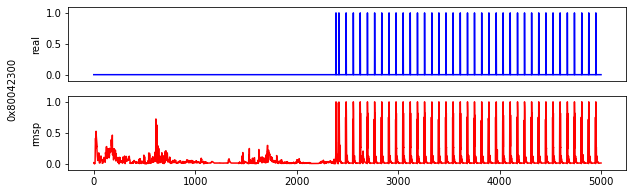

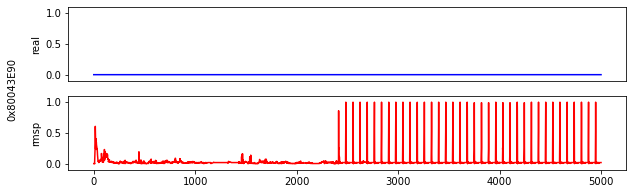

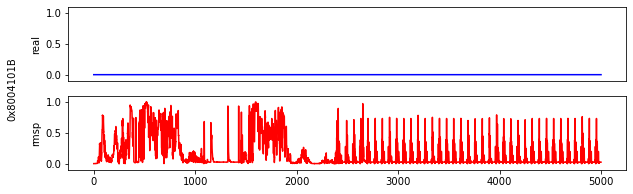

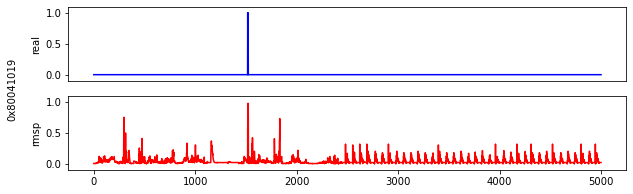

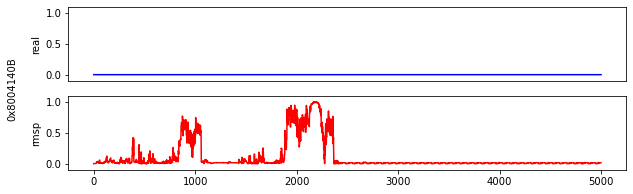

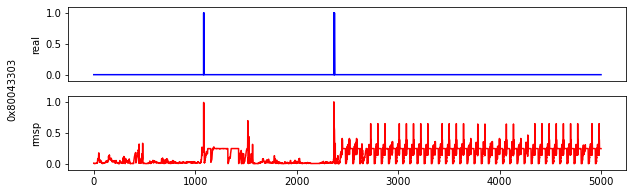

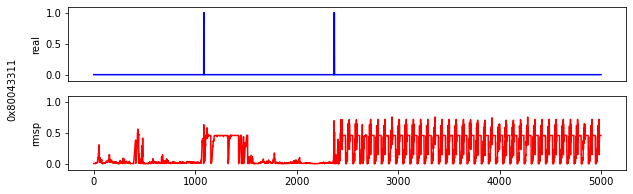

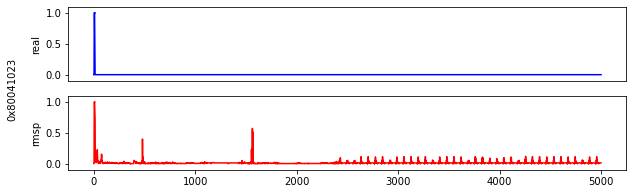

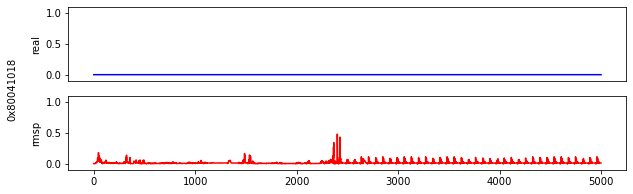

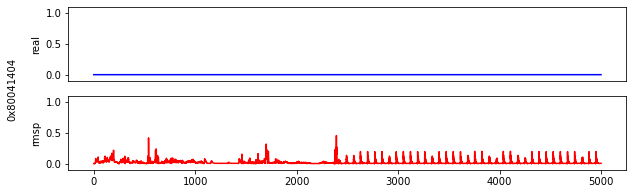

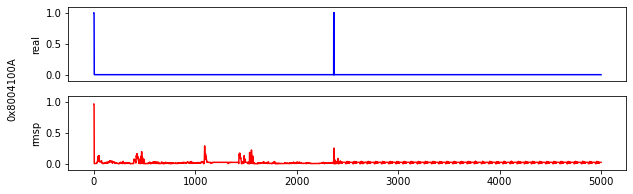

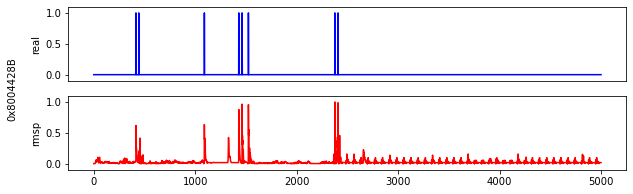

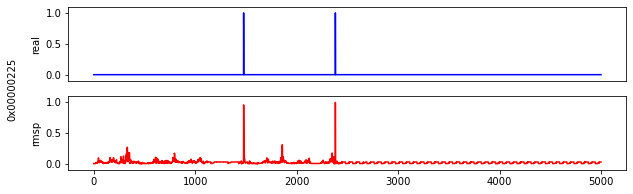

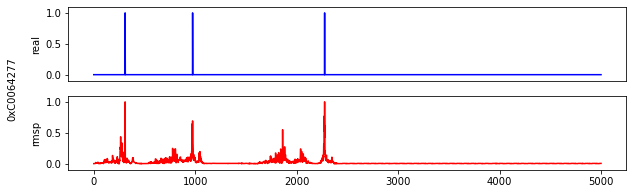

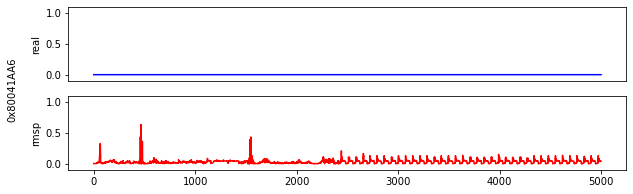

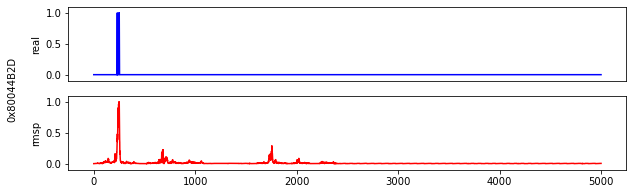

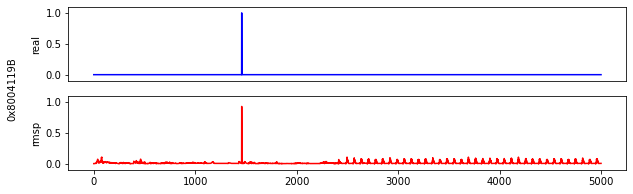

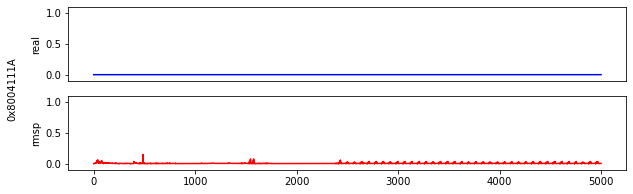

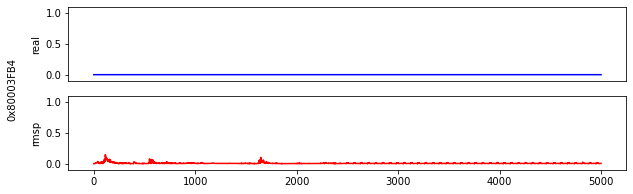

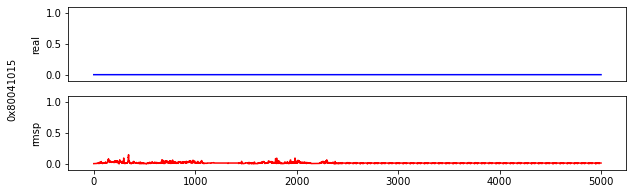

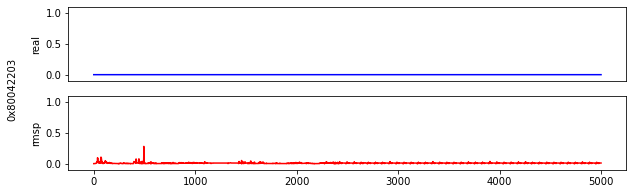

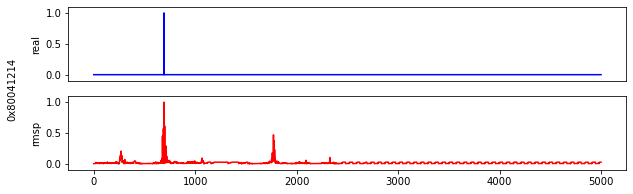

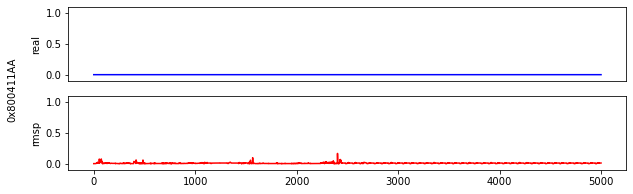

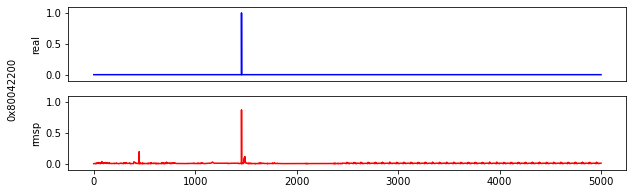

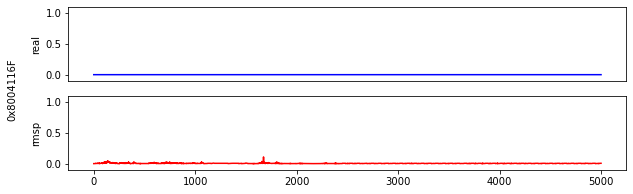

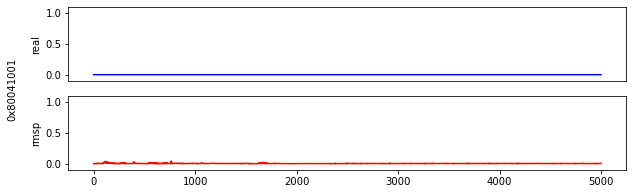

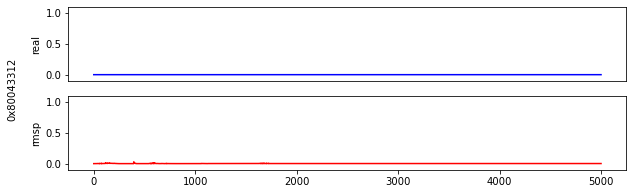

In [163]:
for col in df_pred.columns:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,3))
    
    ax1.plot(df.loc[:, col], color='blue')
    ax1.set_xticks([])
    ax1.set_ylim([-0.1,1.1])
    ax1.set_ylabel('real')
    ax2.plot(df_pred_rmsp.loc[:, col], color='red')
    ax2.set_ylim([-0.1,1.1])
    ax2.set_ylabel('rmsp')
    
    
    fig.text(0.04, 0.5, str(col), va='center', rotation='vertical')

In [ ]:
#Lets try and compare BOW models with it:

In [252]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

labels = message_corpus['ID']
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

VALIDATION_SPLIT = 0.2
indices = np.arange(message_corpus.shape[0])
#print(indices)
np.random.seed(101)
np.random.shuffle(indices)
data = message_corpus.iloc[indices]
labels_encoded = labels_encoded[indices]
labels = labels.iloc[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])


x_train = data['message'][:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data['message'][-num_validation_samples:]
y_val = labels[-num_validation_samples:]

# Convert target variable to one-hot encoded format
#y_train_encoded = to_categorical(y_train, num_classes=27)
#y_val_encoded = to_categorical(y_val, num_classes=27)

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

sgd = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=1, C=1e5)),
              ])

sgd.fit(x_train, y_train)
nb.fit(x_train, y_train)
lr.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [253]:
y_pred_lr = lr.predict(x_val)
y_pred_sgd = sgd.predict(x_val)
y_pred_nb = nb.predict(x_val)

print('accuracy of lr %s' % accuracy_score(y_pred_lr, y_val))
print('accuracy of sgd %s' % accuracy_score(y_pred_sgd, y_val))
print('accuracy of nb %s' % accuracy_score(y_pred_nb, y_val))

accuracy of lr 0.9701353243117126
accuracy of sgd 0.9206719552029865
accuracy of nb 0.6406906206252917


In [259]:
import time
import plotly.graph_objects as os
MAX_SEQUENCE_LENGTH = max(message_corpus['message'].apply(lambda x: len(x.split(' '))))
label_names = label_encoder.inverse_transform(np.unique(labels_encoded))

def get_maxprob_and_label(text, threshold):
    sequence_new = tokenizer.texts_to_sequences(text)
    data = pad_sequences(sequence_new, maxlen=MAX_SEQUENCE_LENGTH)
    
    #cnn validation
    yprob_cnn = model_adam.predict(data)
    yclasses_cnn = yprob_cnn.argmax(axis=-1)
    labelprob_cnn = {label_names[i]: yprob_cnn[0][i] for i in range(len(label_names))}
    
    #naive bayes validation
    y_prob_nb = nb.predict_proba(text)
    labelprob_nb = {nb.classes_[i]: y_prob_nb[0][i] for i in range(len(nb.classes_))}
    
    #lr validation
    y_prob_lr = lr.predict_proba(text)
    labelprob_lr = {lr.classes_[i]: y_prob_lr[0][i] for i in range(len(lr.classes_))}
    
    #sgd validation
    y_prob_sgd = sgd.predict_proba(text)
    labelprob_sgd = {sgd.classes_[i]: y_prob_sgd[0][i] for i in range(len(sgd.classes_))}
    
    #print(label_names, yprob[0][1]), 
    return labelprob_lr, labelprob_nb, labelprob_sgd, labelprob_cnn
    
def get_info_before_eachtimepoint(time, timedelta):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    message = []
    start_date = time - timedelta
    end_date = time
    chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
    message.append(' '.join(chunk['Message']))
    return message


logstash_temp = logstash.iloc[:5000]
logstash_temp.shape


categories = message_corpus.ID.unique()
# Create new columns for each category and initialize with 0

df_cnn = pd.DataFrame()
df_lr = pd.DataFrame()
df_sgd = pd.DataFrame()
df_nb = pd.DataFrame()

for category in categories:
    df_cnn[category] = 0
    df_lr[category] = 0
    df_sgd[category] = 0
    df_nb[category] = 0
    df[category] = 0

for index, row in logstash_temp.iterrows():
    text = get_info_before_eachtimepoint(row['Date'], 5)
    labelprob_lr, labelprob_nb, labelprob_sgd, labelprob_cnn = get_maxprob_and_label(text, 0.80)
    
    column = row['ErrorCode']
    df.at[index, column] = 1
    
    for category in categories:
        df_cnn.at[index, category] = labelprob_cnn[category]
        df_lr.at[index, category] = labelprob_lr[category]
        df_sgd.at[index, category] = labelprob_sgd[category]
        df_nb.at[index, category] = labelprob_nb[category]
        
    #print(len(labelprob_sgd), len(labelprob_cnn))    
    df.fillna(0, inplace=True)
    #df.loc[df[categories].sum(axis=1) == 0, categories] = 0
    #print(str(row['Date'])[0:16] + "| ActualError :" + str(row['ErrorCode']) + "| PredictedError :" + str(label) + "| Probability :" + str(prob)[0:4])
  


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 200ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 200ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 224ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 174ms/step


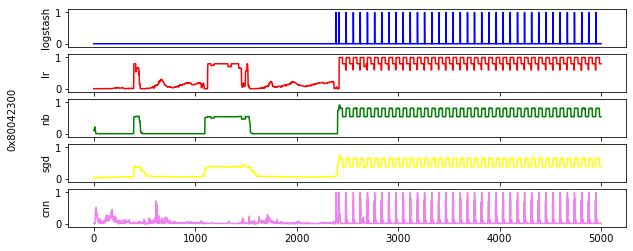

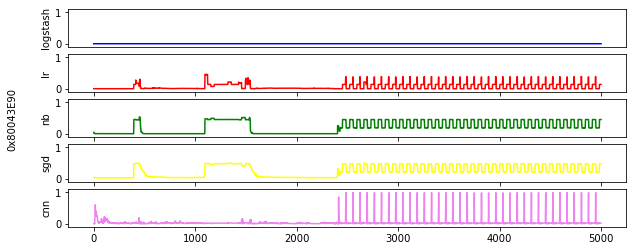

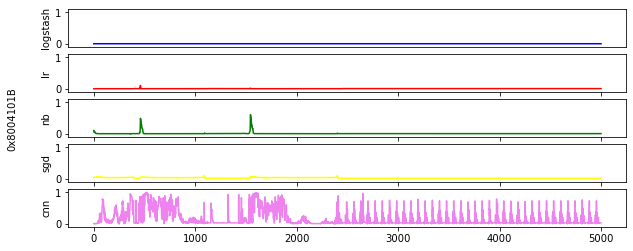

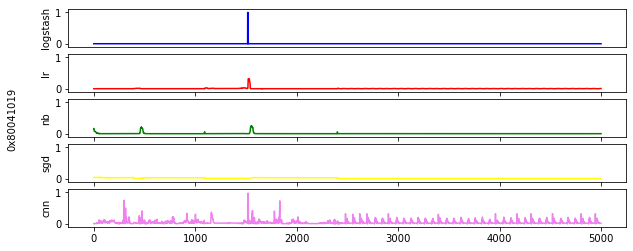

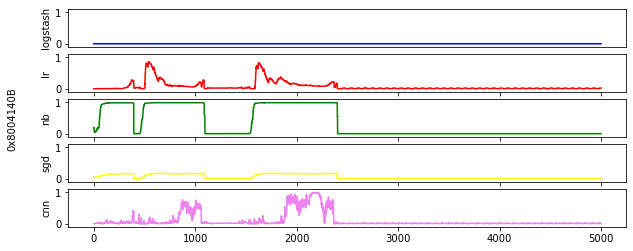

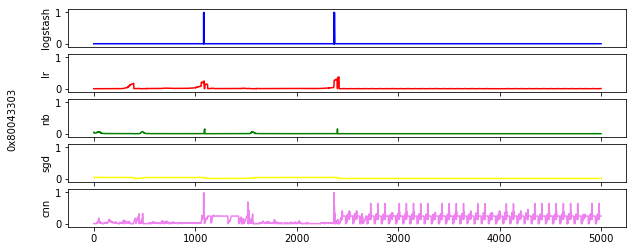

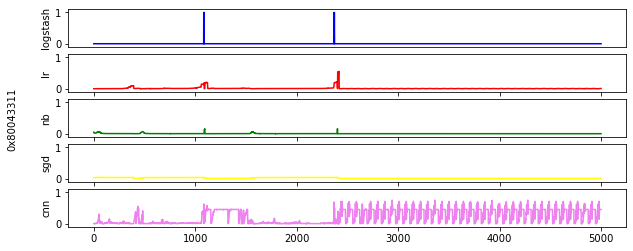

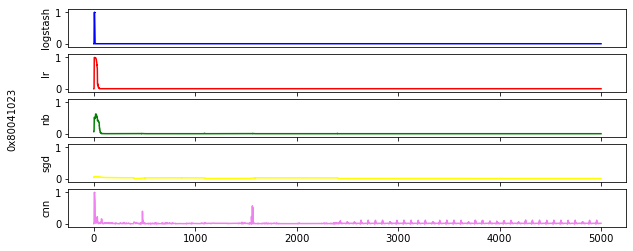

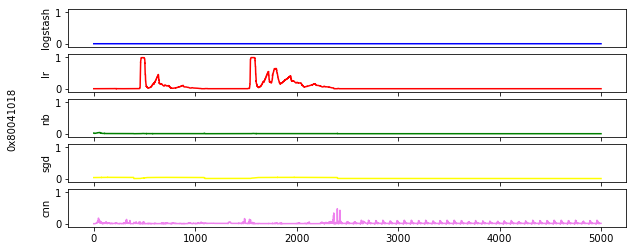

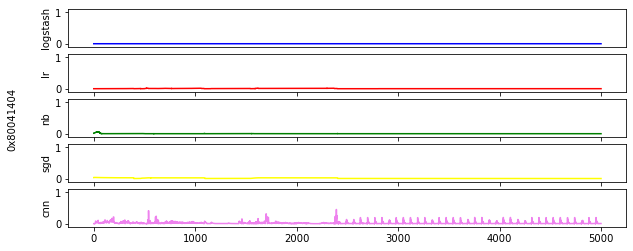

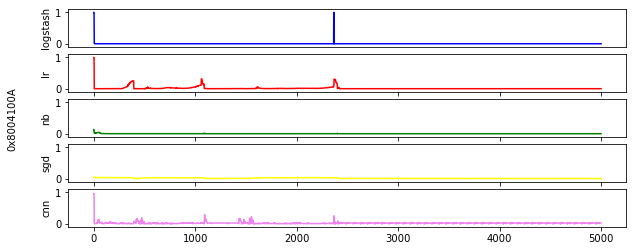

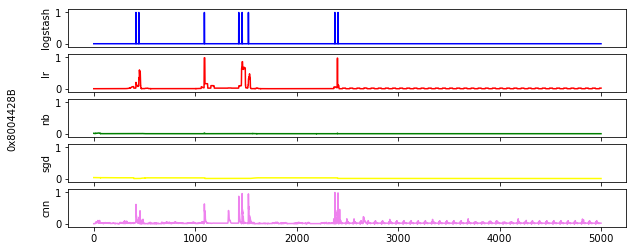

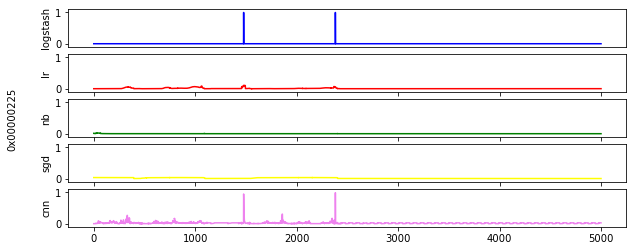

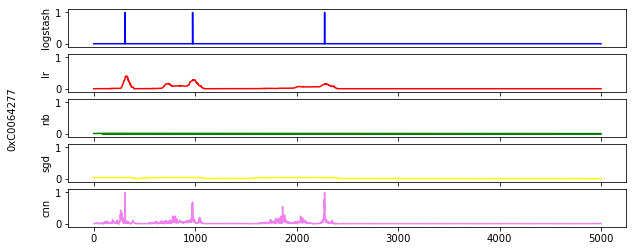

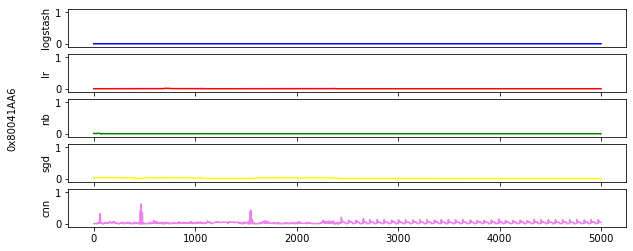

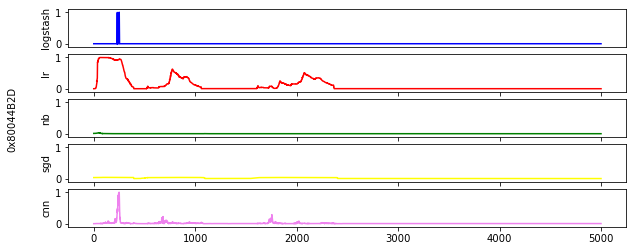

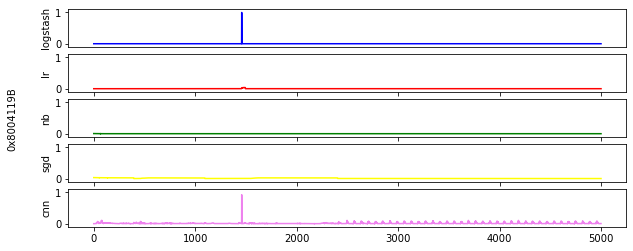

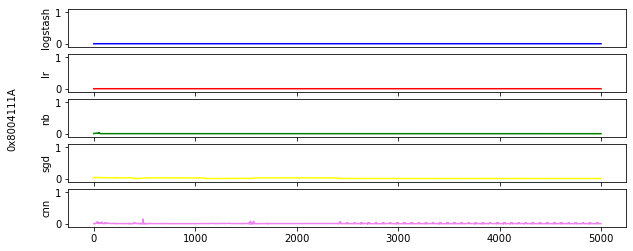

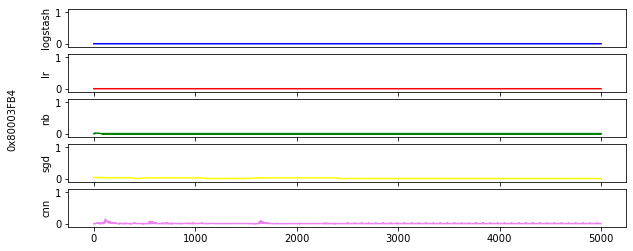

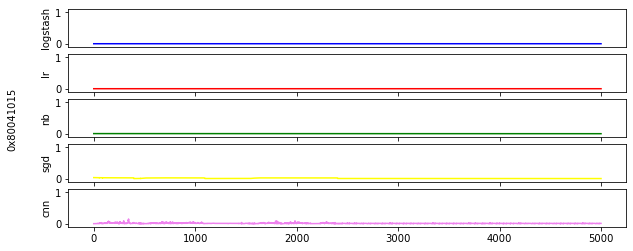

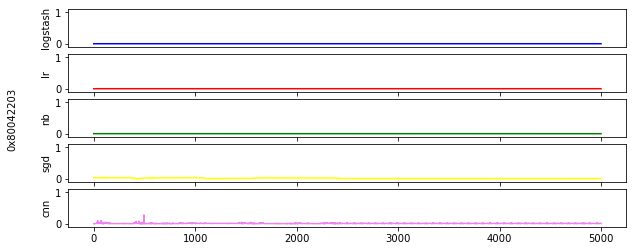

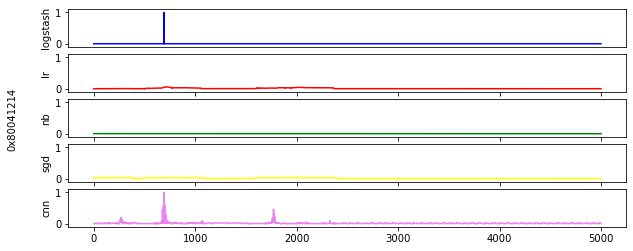

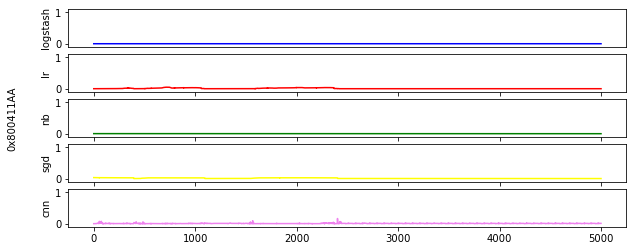

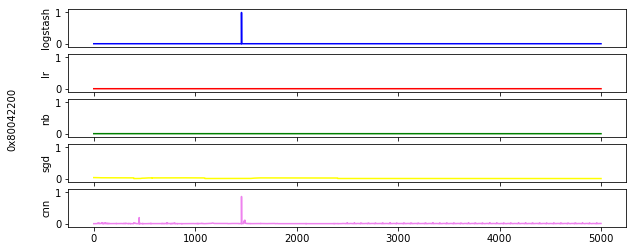

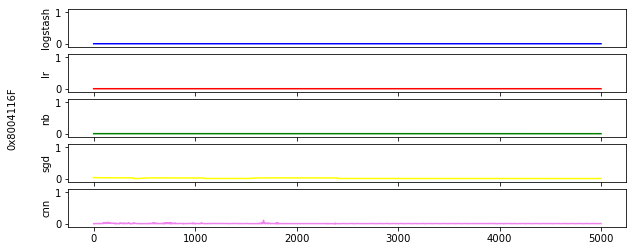

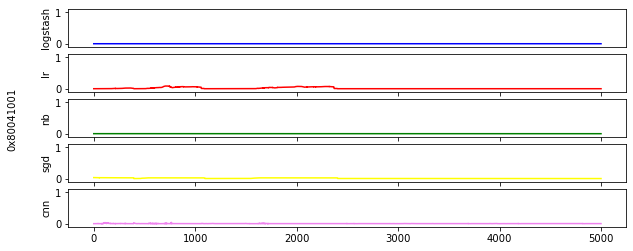

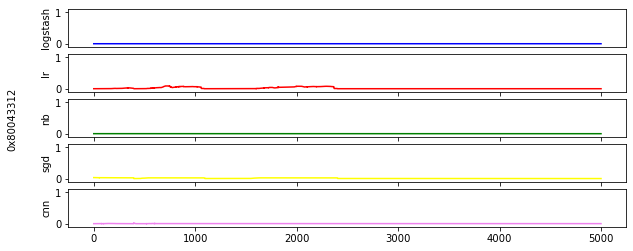

In [260]:
for col in df_pred.columns:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10,4))
    
    ax1.plot(df.loc[:, col], color='blue')
    ax1.set_xticks([])
    ax1.set_ylim([-0.1,1.1])
    ax1.set_ylabel('logstash')
    ax2.plot(df_lr.loc[:, col], color='red')
    ax2.set_ylim([-0.1,1.1])
    ax2.set_ylabel('lr')
    ax3.plot(df_nb.loc[:, col], color='green')
    ax3.set_ylim([-0.1,1.1])
    ax3.set_ylabel('nb')
    ax4.plot(df_sgd.loc[:, col], color='yellow')
    ax4.set_ylim([-0.1,1.1])
    ax4.set_ylabel('sgd')
    ax5.plot(df_cnn.loc[:, col], color='violet')
    ax5.set_ylim([-0.1,1.1])
    ax5.set_ylabel('cnn')
    
    
    fig.text(0.04, 0.5, str(col), va='center', rotation='vertical')